# Python框架语法

## 类 （面向对象编程）


### 核心目的：是通过 “封装、继承、多态” 解决复杂结构的解析与计算问题。

### 1.类的继承关系

在 Python 中，类的继承关系是通过类定义时的括号语法明确的

In [ ]:

class Node:  # 父类（基类）
    def calc(self): pass # 空接口，仅作为借口，子类各自实现具体逻辑
'''
Node是所有语法节点的 “抽象基类”（类似 “模板”），
它不实现具体逻辑，只定义一个calc方法 —— 规定 “所有子类必须能计算关键字出现次数”

这样做的目的是统一接口：无论后续遇到哪种节点（普通关键字、顺序、分支），
都可以用node.calc()调用计算逻辑，无需关心具体类型。
'''


class TokenNode(Node):  # 继承自Node，是Node的子类
    def __init__(self, tok): self.tok = tok
    def calc(self):
        return {self.tok: 1}

'''
封装 “普通关键字” 的数据（如"d"、"k"）和计算逻辑：
单个关键字在命令中必然出现 1 次，因此calc返回{关键字: 1}。
'''
class SequenceNode(Node):  # 继承自Node，是Node的子类
    def __init__(self): self.children = []
    def calc(self):
        res = {}
        for c in self.children:
            for k,v in c.calc().items():
                res[k] = res.get(k, 0) + v
        return res
'''
封装 “顺序结构”（如d r { ... }中d和r的顺序排列）：
多个节点按顺序出现，它们的关键字次数需要累加（因为顺序结构中每个子节点都必须出现）
'''

class BranchNode(Node):  # 继承自Node
    def __init__(self, required):
        self.required = required  # True=大括号（必选），False=中括号（可选）
        self.options = []  # 存储分支中的选项（每个选项是一个SequenceNode）
    def calc(self):
        # 计算每个选项的关键字次数
        maps = [opt.calc() for opt in self.options] 
        # 比如maps = [{"k":1}, {"n":1, "k":1}] --{k|n k} # 第一个选项是"k"，第二个选项是"n k"
        # 可选分支额外加一个“空选项”（表示不选）
        if not self.required:
            maps.append({})
        # 收集所有可能的关键字:收集maps中所有字典里的键（key），并去重后形成一个集合。
        keys = set(k for m in maps for k in m)
        '''
        等价于:
        keys = set()  # 初始化一个空集合
        for m in maps:  # 遍历maps中的每个字典（m是一个字典）
            for k in m:  # 遍历字典m中的每个键（k是关键字）
                keys.add(k)  # 把键k加入集合（自动去重）
        '''
        res = {}
        for k in keys:
            # 取所有选项中该关键字的最小出现次数（必选分支必须选一个，可选分支可以不选）
            mn = min(m.get(k, 0) for m in maps)
            '''
            m.get(k, 0)：如果当前选项m（字典）包含关键字k，则取它的次数；
            如果不包含（即该选项中没有k），则按 0 处理（因为这个选项中k出现 0 次）

            m in maps：遍历所有分支选项的字典eg: dic1 | dic2 的结构: {k|n k}
            以|来划分选项，dic1是一个选项，dic2是另一个选项
            '''
            if mn > 0:  # 只有所有选项都至少出现mn次，才是必选关键字
                res[k] = mn
        return res

'''
封装 “分支结构”（大括号{a | b}或中括号[a | b]）：
多个选项选其一，关键字的最小出现次数取所有选项中的最小值
（因为必须满足 “无论选哪个选项，该关键字都至少出现这么多次”）
'''

In [ ]:
# 主程序：解析输入，构建语法树，计算结果
tokens = sys.stdin.read().strip().split()
pos = 0

# 使用上面的类:
def parse_branch(): # 解析分支结构，返回BranchNode
    global pos  # 使用全局的pos指针
    # 1. 判断分支类型（必选/可选）：当前令牌是'{'则必选（req=True），'['则可选（req=False）
    req = tokens[pos] == '{'  # 样例1中，此时pos=2，tokens[2]='{'，所以req=True
    pos += 1  # 指针后移，跳过'{'或'['（样例1中pos变为3）
    
    # 2. 创建分支节点（BranchNode），传入是否必选的标记
    bn = BranchNode(req)  # 样例1中，bn.required = True
    
    # 3. 循环解析括号内的所有选项（直到遇到闭合符号'}'或']'）
    # 循环条件：当前令牌不是闭合符号（必选分支找'}'，可选分支找']'）
    while tokens[pos] != ('}' if req else ']'):  # 样例1中，找'}'，此时pos=3，tokens[3]='k'≠'}'，进入循环
        
        # 3.1 每个选项都是一个“顺序结构”，用SequenceNode存储
        seq = SequenceNode()  # 新建一个顺序节点，存储当前选项的内容
        
        # 3.2 解析当前选项的内容（直到遇到'|'（选项分隔符）或闭合符号）
        while tokens[pos] not in ['|', '}', ']']:  # 找'|'或'}'，当前pos=3，tokens[3]='k'不在其中，进入循环
            if tokens[pos] in ['{', '[']:  # 如果遇到嵌套的分支符号，递归解析
                # 递归调用parse_branch()解析嵌套分支，结果加入当前顺序节点
                seq.children.append(parse_branch())
            else:  # 否则是普通关键字，创建TokenNode加入顺序节点
                seq.children.append(TokenNode(tokens[pos]))  # 样例1中，tokens[3]='k'，创建TokenNode("k")
                pos += 1  # 指针后移（样例1中pos变为4）
        
        # 3.3 当前选项解析完成，加入分支节点的options列表
        bn.options.append(seq)  # 样例1中，第一个选项seq包含TokenNode("k")，加入bn.options
        
        # 3.4 如果当前令牌是'|'（选项分隔符），指针后移跳过'|'
        if tokens[pos] == '|':  # 样例1中，此时pos=4，tokens[4]='|'，进入条件
            pos += 1  # 指针后移（pos变为5）
    
    # 4. 解析完所有选项后，指针后移跳过闭合符号'}'或']'
    pos += 1  # 样例1中，循环结束时pos=7（tokens[7]='}'），跳过'}'后pos=8
    
    # 5. 返回解析好的分支节点
    return bn  # 样例1中，bn.options包含两个选项：[seq1, seq2]，其中seq1是[k]，seq2是[n, k]

def parse_node(): # 解析顺序结构，返回SequenceNode
    global pos  # 使用全局的pos指针
    # 1. 创建顺序节点，存储当前解析的顺序结构
    seq = SequenceNode()
    
    # 2. 循环解析令牌，直到结束或遇到闭合符号（分支的结束）
    # 循环条件：pos未超出tokens长度，且当前令牌不是闭合符号（'}'用于退出分支内的顺序解析）
    while pos < len(tokens) and tokens[pos] not in ['}', '']:  # 样例1中，初始pos=0，tokens[0]='d'，进入循环
        
        if tokens[pos] in ['{', '[']:  # 如果遇到分支符号，调用parse_branch()解析分支
            # 解析分支后，将分支节点加入当前顺序节点
            seq.children.append(parse_branch())  # 样例1中，pos=2时遇到'{'，调用parse_branch()返回bn，加入children
        elif tokens[pos] in ['}', '|', ']']:  # 如果遇到分支内的分隔符或闭合符，停止当前顺序解析
            break
        else:  # 否则是普通关键字，创建TokenNode加入顺序节点
            seq.children.append(TokenNode(tokens[pos]))  # 样例1中，pos=0时tokens[0]='d'，创建TokenNode("d")
            pos += 1  # 指针后移（pos变为1）
    
    # 3. 返回解析好的顺序节点
    return seq  # 样例1中，seq.children包含：TokenNode("d")、TokenNode("r")、bn（分支节点）

# 主程序逻辑
# 1. 解析整个令牌列表，生成根节点（语法树的根）


root = parse_node()  # 根节点是最外层的SequenceNode（如样例1的seq_root）

# 2. 调用根节点的calc()方法，计算所有必选关键字的最小出现次数
mp = root.calc()  # 样例1中，root.calc()会累加d(1)、r(1)、分支的k(1)，得到{"d":1, "r":1, "k":1}

# 3. 处理结果：筛选出次数>0的关键字，按字母顺序排序
ans = sorted((k, v) for k, v in mp.items() if v > 0)  # 样例1中，排序后为[("d",1), ("k",1), ("r",1)]

# 4. 输出：第一行关键字，第二行对应次数
print(' '.join(k for k, _ in ans))  # 输出"d k r"
print(' '.join(str(v) for _, v in ans))  # 输出"1 1 1"

### 1.多态
多个类中定义同名方法（如calc(self)）的语法，本质上是面向对象编程中 “多态”（Polymorphism） 的体现，具体通过 “方法重写（Override）” 实现。

子类可以重写父类中定义的方法（这里父类Node的calc是一个空接口，子类各自实现具体逻辑），即：

子类定义与父类同名的方法（参数列表需一致，这里都是self）；

不同子类可以对该方法有不同的实现（比如TokenNode的calc返回关键词出现 1 次，SequenceNode的
calc累加子节点结果等）。

#### 2. 如何确定调用哪个类的方法（以calc为例）？

调用时，Python 会根据对象的实际类型动态绑定方法（即 “运行时绑定”）。
- 举个例子：
假设我们有一个变量node，它可能指向TokenNode的实例，也可能指向SequenceNode或BranchNode的实例。当执行node.calc()时：
如果node是TokenNode的实例，就调用TokenNode类的calc；
如果node是SequenceNode的实例，就调用SequenceNode类的calc；
以此类推。

## 0.标准输入输出

### 扩充栈深


In [3]:
import sys
sys.setrecursionlimit(10000)

### 列表查找元素：
idx=inorder.index(root_val)

### 输入
1.n,k=map(int,input().strip().strip())

#### 0. strip(), replace()的用法

##### 1. str.strip(chars) 的工作原理
- strip(chars) 的参数 chars 是一个字符串，表示需要删除的字符集合。
- 它会从字符串的两端开始检查，逐个删除字符，直到遇到第一个不在 chars 中的字符为止。
- 不是精确匹配整个字符串，而是逐个字符检查是否属于指定集合

##### 2.和replace的区别
- strip("[]")：只删除字符串两端的 [ 或 ]。

    示例："[1,2]" → "1,2"。

- replace：会删除字符串中所有匹配的字符。

    示例："[1,2]".replace("[", "").replace("]", "") → "1,2"。

#### 1.sys中的输入

In [4]:
sensor=[]
    for line in  sys.stdin:
        line=line.strip()
        if not line:
            continue
        a,b=map(int,line.split())
        sensor.append([a,b])
    if not sensor:
        sys.exit(0)

IndentationError: unexpected indent (3718808055.py, line 2)

#### 1.1 逐行读取到一个列表中---每一行作为一个列表中的元素

In [ ]:
for line in sys.stdin:
    line=line.strip()
    listall=list(map(int,line.split()))


In [ ]:
 intervals = [list(map(int, input().split())) for _ in range(n)]  # 逐行读取输入，每一行作为一个列表中的元素


1. 使用`sys.stdin`可以逐行读取标准输入，通过for循环遍历每一行输入内容。
2. 对每一行使用`line.strip()`去除首尾空白字符，并用if判断跳过空行。
3. 使用`map(int,line.split())`将每行的字符串按空格分割并转换为整数，然后赋值给变量。
4. 将处理后的数据存储在列表中（如sensor），当没有输入数据时使用`sys.exit(0)`退出程序。

这四句话概括了你选中代码中处理标准输入的核心要点。

#### 2.1 sys.stdin.read
在 Python 中，sys.stdin 代表 “标准输入流”（通常是键盘输入，或通过管道 / 文件传入的输入），它是一个类文件对象，支持文件对象的常用方法。

sys.stdin.read() 中的 read() 是这个流对象的一个方法，

1. 作用是：一次性读取输入流中的所有数据，直到结束（遇到 EOF，即 “文件结束符”），并将读取到的内容以字符串形式返回。

 返回的是输入数据的字符串!

#### 3.邻接表和邻接矩阵的输入

In [ ]:
if __name__ == "__main__":
    import sys 
    input = sys.stdin.readline
    n = int(input().strip())
    A = [[0]*n for _ in range(n+1)]
    adj_B = [[] for _ in range(n+1)]
    for i in range(1,n+1):
        A[i] = list(map(int, input().strip().split()))
    for j in range(n):
        data = list(map(int, input().strip().split()))
        k = data[1]
        neighbors = data[2:]
        adj_B[data[0]].extend(neighbors)

#### 3.1 邻接表的字典形式!!!

In [ ]:
def main():
    import sys
    input = sys.stdin.read
    data = input().split()
    idx = 0
    n = int(data[idx])
    idx += 1
    start, end = data[idx], data[idx + 1]
    idx += 2
    grap = {} 
    
    while data[idx] != "0000":
        st1, st2 = data[idx], data[idx + 1]
        t = int(data[idx + 2])
        if st1 not in grap:   # 核心!字典中没有键时，添加键!
            grap[st1] = []    # 核心!
        grap[st1].append((st2, t)) 
        if st2 not in grap:
            grap[st2] = []
        grap[st2].append((st1, t))  
        idx += 3

#### 3.deque()的初始化注意
deque() 初始化时需要传入一个可迭代对象（如列表、元组等）
deque([start]）是对的
但是deque(start) 是不对的

### 2.输出

#### 1.f-string写法

print(f"{inter[0]} {inter[1]}")   f-string写法

解释：
1.  前缀：
字符串前的 f 是关键标记，告诉 Python：“这个字符串里有需要动态替换的变量 / 表达式，请解析它们的值并拼接成最终字符串”。
2. {} 占位符：
字符串中的 {inter[0]} 和 {inter[1]} 是 “占位符”，Python 会自动计算 inter[0] 和 inter[1] 的值，然后用这些值替换占位符。
假设 inter 是一个区间列表（比如 [1, 6]），那么 inter[0] 的值是 1，inter[1] 的值是 6。
3. 最终字符串拼接：
替换后，f"{inter[0]} {inter[1]}" 会变成 "1 6"（以 inter = [1,6] 为例），再通过 print() 函数输出到控制台，正好符合题目 “每行输出一个区间，用空格分隔两个数字” 的要求。

print(f"{inter[0]} {inter[1]}") 

#### 2."".join写法

" ".join(iterable) 需要传入一个可迭代对象（如列表）
连接符.join(可迭代对象)
1. 连接符：一个字符串（比如 " " 空格、"," 逗号、"-" 横线等），用于分隔可迭代对象中的元素。
2. 可迭代对象：可以是列表、元组、字符串、集合等（只要是能被循环遍历的对象），且其中的元素必须是字符串类型（或能被隐式转为字符串的类型，否则会报错）。



In [ ]:
print(" ".join(map(str, result)))

In [ ]:
# 可迭代对象是列表，元素都是字符串
words = ["hello", "world", "python"]
# 用空格 " " 作为连接符
result = " ".join(words)
print(result)  # 输出：hello world python

#### 3.将字符串列表输出为数字:

In [ ]:
int("".join(sa))

#### 4.将字母转成a-z的ascii码

- ord(character) 将字符转换成ASCII码

- chr(ascii_code) 将ASCII码转换成字符

## 1.缓存功能(记忆性搜索)

In [ ]:
import functools

@functools.cache  # 替代 lru_cache(maxsize=None)，更简洁
def unique_paths(m: int, n: int) -> int:
    if m == 1 and n == 1:
        return 1
    if m == 1:
        return 1
    if n == 1:
        return 1
    return unique_paths(m-1, n) + unique_paths(m, n-1)

print(unique_paths(3, 7))  # 结果为 28，与使用 lru_cache 完全一致

## 2.常用内置函数

### 1.大小写字母转换

同一个字母的小写 ASCII 码比大写大 32

In [ ]:
# 大小写字母转换
text = "HELLO WORLD"
lower_text = text.lower()
print(lower_text)  # 输出: hello world

# 小写转大写
text = "hello world"
upper_text = text.upper()
print(upper_text)  # 输出: HELLO WORLD

# 正式做题笔记

## 1.哈希表


### 0.常用字典库操作

#### 1.dict.get(key[, default])

```python
# 创建一个字典
my_dict = {'a': 1, 'b': 2, 'c': 3}

# 使用get方法获取存在的键
print(my_dict.get('a'))           # 输出: 1

# 使用get方法获取不存在的键，不提供默认值
print(my_dict.get('d'))           # 输出: None

# 使用get方法获取不存在的键，提供默认值
print(my_dict.get('d', 0))        # 输出: 0
print(my_dict.get('d', 'Not Found'))  # 输出: Not Found
```

#### 2.keys() values() items()

所有的键
```python
# 假设你有一个字典
my_dict = {'a': 1, 'b': 2, 'c': 3}

# 获取所有键
keys = my_dict.keys()

# 转换为列表（如果需要的话）
keys_list = list(my_dict.keys())

print(keys)        # 输出: dict_keys(['a', 'b', 'c'])
print(keys_list)   # 输出: ['a', 'b', 'c']
```

所有的值和键值对
```python
# 获取所有值
values = list(my_dict.values())
print(values)  # 输出: [1, 2, 3]

# 获取所有键值对
items = list(my_dict.items())
print(items)   # 输出: [('a', 1), ('b', 2), ('c', 3)]
```

#### 3.自动初始化--defaultdict(list) 

##### 使用定义好的list,int之类的
```python
from collections import defaultdict
dict = defaultdict(list) # 创建一个字典,当访问一个不存在的键时，会自动为该键创建一个默认值（这里的默认值是一个空列表 []）。
```

##### 还可以用自定义的lambda!
```python
dict2 = defaultdict(lambda: [0, 0]) # 使用 lambda 创建包含两个整数的列表
```

### 1.转换思路之 数组中选两数求和为目标值---a+b=target
- 创建一个字典，将nums中的元素作为key，索引作为value
- 遍历nums，判断target-nums[i]是否在字典中，是则返回结果,否，则将nums[i]作为key，索引作为value加入字典!
- 时间复杂度：O(n)
- 空间复杂度：O(n)

In [ ]:
n,target=map(int,input().split())
nums=list(map(int,input().split()))
dic={}
for i in range(n):
    complement=target-nums[i]
    if complement in dic:
        print(dic[complement],i)
        exit()
    dic[nums[i]]=i

### 2.怎么选取健和值--字母异位词分组
思路:
1. 创建一个字典，key为排序后的字符串，value为列表，列表中存放的是原字符串---这样异位词组的健就是一样的!
=================================================================================
2. 遍历字符串列表，将字符串排序，并作为key，将原字符串作为value添加到字典中
3. 遍历字典，将value列表中的字符串添加到一个新的列表中，并返回新的列表

学:
1.注意!:sorted(s) 返回的是列表（list），而列表是不可哈希的,所以不能作为字典的key--要用key="".join(sorted(s))
2.用collections中的defaultdict来创建字典--默认字典，字典的key不存在时，会创建一个空的列表，并返回该列表
3."".join(Listt)来将列表Listt中的元素连接成一个字符串

In [ ]:
from collections import defaultdict
class solution:
    def groupanagrams(self,strs):
        mp=defaultdict(list)
        for s in strs:
            key="".join(sorted(s))
            mp[key].append(s)
        return list(mp.values())
if __name__=="__main__":
    n=int(input())
    strs=input().split()
    so=solution()
    res=so.groupanagrams(strs)
    for group in res:
        #print(" ".join(group))
        print(*group)

### 3.巨帅的贪心哈希解法--最长连续序列

学:

1.**利用set(nums)方便查找nums[i]-1/nums[i]+1是否在nums中---set()查找效率高O(1)!!!!!**

2.nums[i]-1不在set(nums)中说明其就是一个序列的起点

3.nums[i]+1在set(nums)中,说明该序列长度可以增加--le+=1,一直到找不到为止就是nums[i]序列的最终连续长度

4.maxlen = max(maxlen, le)找到最长长度

In [ ]:
from collections import deque
class solution:
    def maxsequence(self,nums):
        maxle=0
        setnums=set(nums)
        for i in range(len(nums)):
            if (nums[i]-1) not in setnums:
                le=1
                while (nums[i]+le) in setnums:
                    le+=1
                maxle=max(maxle,le)
            else:
                continue
        return maxle

so=solution()
n=int(input())
nums=list(map(int,input().split()))
print(so.maxsequence(nums))


### 4.技巧--字符为key,出现次数为value
dict.get(key, default) 可以获取键 key 对应的值，若键不存在则返回 default（这里用 0 作为默认值）。


In [ ]:
from collections import defaultdict

class Solution:
    def allsubword(self, s, p):
        ns, np = len(s), len(p)
        dic = {}  # 存储p中字符的出现次数
        for char in p:  # 直接遍历p中的每个字符（比用索引更直观）
            # 若char在dic中，获取其当前值+1；若不在，用0+1（即初始化为1）
            dic[char] = dic.get(char, 0) + 1
        return dic  # 测试用，实际可根据需求处理

5.技巧--删除字典中的健

In [ ]:
del scount[s[i-np]]

NameError: name 'scount' is not defined

### 6.技巧使用Counter
from collections import Counter

Counter 的内容以 键值对 的形式存储，与普通字典类似：
键（key）：被计数的元素（比如字符串中的每个字符、列表中的每个元素等）。
值（value）：该元素出现的次数（非负整数）。

## 2.双指针

### 1.同起点/紧挨着的双指针--移动零

两种思路:
1.挨个判断0移动到后面---需要考虑更多边界条件
2.移动非0到前面---更简洁,但会自己移动自己

In [ ]:
# 移动0 -后移
class solution:
    def movezero(self,nums):
        left=0
        right=1
        while right<len(nums):
            if nums[left]==0 and nums[right]!=0:
                nums[left],nums[right]=nums[right],nums[left]
                right+=1
                left+=1
            elif nums[left]==0:
                if nums[right]==0:
                    right+=1
            else:
                right+=1
                left+=1
so=solution()
n=int(input())
nums=list(map(int,input().split()))
so.movezero(nums)
print(*nums)



In [ ]:
# 移动非0--前移
class Solution:
    def moveZeroes(self, nums):
        n = len(nums)
        i = 0  # 记录非零元素应放置的位置
        
        # 遍历数组，将非零元素移到前面
        for j in range(n):
            if nums[j] != 0:
                nums[i], nums[j] = nums[j], nums[i]  # 交换非零元素到前面
                i += 1  # 移动非零元素位置索引

# 读入数据并调用函数
n = int(input().strip())
nums = list(map(int, input().split()))
Solution().moveZeroes(nums)
print(" ".join(map(str, nums)))


### 2.两头指针移动之优化(贪心)多移动其中一头--盛水最多容器

学:
1.我在想优化双指针，移动指针的时候跳过比当前短板更短的时候,循环没写好容易写成死循环,要记住这样写!:
    cur_left=nums[left] #要在循环外定义cur_left,方便比较
    while left < right and nums[left]<=cur_left:
                    left+=1 #只在循环里面叠加
        不要忘记判断left<right且将nums[left]<=cur_left:放入同级别的while中

In [ ]:
class solution:
    def maxwater(self,nums):
        left=0
        right=len(nums)-1
        res=0        
        while left<right:
            v=min(nums[left],nums[right])*(right-left)
            res=max(res,v)
            if nums[left]<nums[right]:
                cur_left=nums[left]
                while left < right and nums[left]<=cur_left:
                    left+=1
                    
            else:
                cur_right=nums[right]
                while left < right and nums[right]<=cur_right:
                    right-=1
                        
        return res
so=solution()
n=int(input())
nums=list(map(int,input().split()))
print(so.maxwater(nums))
                

### 3.三个指针（去重写法）--三数之和

学：

1.固定一个指针i，滑动窗口两个指针k=i+1,j=len(nums)-1开始滑

2.每次i的循环注意k=i+1,j=len(nums)-1要重新初始化

3.去重的时候主要在（1）i的外循环注意and边界条件i<len(nums）-2)（2）内循环total=0的时候（注意and边界条件k<j）


In [ ]:
class Solution:
    def threeSum(self, nums):
        """
        三数之和，双指针法
        :param nums: List[int] 代表输入数组
        :return: List[List[int]] 符合条件的三元组列表
        """
        nums.sort()  # 先排序
        n = len(nums)
        res = []

        for i in range(n - 2):
            if i > 0 and nums[i] == nums[i - 1]:  # 跳过重复元素
                continue

            left, right = i + 1, n - 1  # 左右指针
            while left < right:
                total = nums[i] + nums[left] + nums[right]
                if total < 0:
                    left += 1
                elif total > 0:
                    right -= 1
                else:
                    res.append([nums[i], nums[left], nums[right]])
                    # 跳过重复元素
                    while left < right and nums[left] == nums[left + 1]:
                        left += 1
                    while left < right and nums[right] == nums[right - 1]:
                        right -= 1
                    left += 1
                    right -= 1
        return res

# 读取输入
if __name__ == "__main__":
    n = int(input())  # 读取 n
    nums = list(map(int, input().split()))  # 读取数组
    solution = Solution()
    results = solution.threeSum(nums)
    for triplet in results:
        print(" ".join(map(str, triplet)))


### 1.在滑动（滑动得前缀后缀max）的时候就根据贪心计算当前值--接雨水

学：

1.可以边滑动边计算值的原因：
当 height[left] < height[right] 时，我们可以确定：
右侧一定存在一个比 height[left] 更高的柱子（至少 height[right] 就是）。
因此，left 位置的存水量只取决于左侧的最大高度（left_max），因为右侧的最大高度无论如何都不会小于 height[right]（而 height[right] 已经比 height[left] 大了）

省空间！
利用了贪心思想

In [ ]:
class Solution:
    def trap(self, height):
        if not height:
            return 0
        
        left, right = 0, len(height) - 1
        left_max, right_max = 0, 0
        water = 0
        
        while left < right:
            if height[left] < height[right]:
                if height[left] >= left_max:
                    left_max = height[left]
                else:
                    water += left_max - height[left]
                left += 1
            else:
                if height[right] >= right_max:
                    right_max = height[right]
                else:
                    water += right_max - height[right]
                right -= 1
        
        return water

# 读取输入并处理
if __name__ == "__main__":
    n = int(input())
    height = list(map(int, input().split()))
    solution = Solution()
    print(solution.trap(height))


## 3.滑动窗口（双指针的子集）-双指针+连续区间

### 1.滑动窗口的left可以用for循环，right用while循环（逻辑清楚）--求无重复的最长子串

学：

1.用集合set()来判断重复元素--查找，添加，删除的时间复杂度都是O(1)

2.s=str(input())或者s= input()--字符串本身就是可迭代的，不需要用list()



In [ ]:
class Solution:
    def maxsubstr(self,s):
        n=len(s)
        record=set()
        i=0
        maxlen=0
        for j in range(n):
            while s[j] in record:               
                record.discard(s[i])
                i+=1
            record.add(s[j])
            maxlen=max(maxlen,j-i+1)
                
        return maxlen
so=Solution()
s=str(input())
print(so.maxsubstr(s))
                


### 2.单调队列/二叉堆辅助--滑动窗口的最大值

##### 1.双端单调队列的求法: 时间复杂度为O(n),空间复杂度O(k)

：用单调递减队列仅保留窗口内 “候选最大值” 的索引，队头直接为当前窗口最大值，通过清理过期元素和较小元素维持高效。

**压栈的思想!** + 队头元素判断是否在窗口内(popleft)


In [ ]:
from collections import deque
import sys

class Solution:
    def maxSlidingWindow(self, nums, k):
        deque_window = deque()  # 双端队列
        result = []
        
        for i in range(len(nums)):
            # 移除窗口左侧已过期的元素索引
            if deque_window and deque_window[0] < i - k + 1:
                deque_window.popleft()
            
            # 保持队列单调递减，移除所有小于当前元素的索引
            while deque_window and nums[deque_window[-1]] < nums[i]:
                deque_window.pop()
            
            # 添加当前元素索引
            deque_window.append(i)
            
            # 记录最大值（窗口形成后）
            if i >= k - 1:
                result.append(nums[deque_window[0]])

        return result

if __name__ == "__main__":
    # 读取输入
    n, k = map(int, sys.stdin.readline().split())
    nums = list(map(int, sys.stdin.readline().split()))
    
    # 计算滑动窗口最大值
    solution = Solution()
    result = solution.maxSlidingWindow(nums, k)
    
    # 输出结果
    print(" ".join(map(str, result)))


##### 2.二叉堆解法--时间复杂度O(nlogk),空间复杂度O(k)
用堆存储窗口元素（含索引），借堆顶快速获取最大值，同时通过索引过滤超出窗口的过期元素。

In [ ]:
from collections import deque
import sys

class Solution:
    def maxSlidingWindow(self, nums, k):
        deque_window = deque()  # 双端队列
        result = []
        
        for i in range(len(nums)):
            # 移除窗口左侧已过期的元素索引
            if deque_window and deque_window[0] < i - k + 1:
                deque_window.popleft()
            
            # 保持队列单调递减，移除所有小于当前元素的索引
            while deque_window and nums[deque_window[-1]] < nums[i]:
                deque_window.pop()
            
            # 添加当前元素索引
            deque_window.append(i)
            
            # 记录最大值（窗口形成后）
            if i >= k - 1:
                result.append(nums[deque_window[0]])

        return result

if __name__ == "__main__":
    # 读取输入
    n, k = map(int, sys.stdin.readline().split())
    nums = list(map(int, sys.stdin.readline().split()))
    
    # 计算滑动窗口最大值
    solution = Solution()
    result = solution.maxSlidingWindow(nums, k)
    
    # 输出结果
    print(" ".join(map(str, result)))


二叉堆方法依赖堆结构存储窗口元素（含过期元素），借堆顶取最大值--存了值和索引；单调队列方法则通过维持单调性仅保留窗口内有效候选元素，直接从队头取最大值--只存索引。

### 3.使用字典辅助(Counter)--找到字符串中所有异位词

1. 采用固定大小（与p长度一致）的滑动窗口遍历s，通过字符频率计数（Counter）匹配异位词。
2. 窗口滑动时仅更新新增和移除的字符计数，避免重复计算整个窗口，提升效率。
3. 若当前窗口与pcounter一致，即字符频率完全一致，则记录窗口起始索引，即为有效异位词位置。

In [ ]:
from collections import Counter

class Solution:
    def findAnagrams(self, s: str, p: str):
        p_len, s_len = len(p), len(s)
        if s_len < p_len:
            return []

        # 记录 p 的字符计数
        p_count = Counter(p)
        s_count = Counter(s[:p_len])  # 统计第一个窗口的字符

        res = []
        if p_count == s_count:
            res.append(0)

        for i in range(p_len, s_len):
            # 新增字符
            s_count[s[i]] += 1
            # 移除窗口左端字符
            s_count[s[i - p_len]] -= 1
            if s_count[s[i - p_len]] == 0:
                del s_count[s[i - p_len]]

            # 检查窗口是否匹配
            if s_count == p_count:
                res.append(i - p_len + 1)

        return res

# 读取输入
s = input().strip()
p = input().strip()
solution = Solution()
result = solution.findAnagrams(s, p)
print(" ".join(map(str, result)))


时间复杂度分析

 1. 初始化 p_count 和 s_count 需要 O(m)，其中 m 是 p 的长度。
 2. 滑动窗口遍历 s 需要 O(n)。
 3. 比较两个哈希表（数组） 需要 O(1)（因为最多26个字母）。
 4. 总时间复杂度 为 O(n+m)。
 5. 空间复杂度为 O(26)。


## 4.子串技巧汇总

### 1.前缀和技巧（结合哈希表应对前缀和出现重复的情况--sums中有负数）--和为k的子数组(连续)
哈希表记录健为presum[i]出现的次数!
dic[presum[i]]=dic.get(presum[i],0)+1  


学规范

前缀和代码标准：
        n=len(nums)
        presum=[0]*(n+1)
        for i in range(1,n+1):
            presum[i]=presum[i-1]+nums[i-1]

In [ ]:
class Solution:
    def sumksubseq(self,nums,k):
        n=len(nums)
        presum=[0]*(n+1)
        dic={0:1}
        res=0
        for i in range(1,n+1):
            presum[i]=presum[i-1]+nums[i-1]
            res+=dic.get(presum[i]-k,0)
            dic[presum[i]]=dic.get(presum[i],0)+1            
        return res

if __name__ == "__main__":
    n,k=map(int,input().strip().split())   
    nums = list(map(int, input().strip().split()))
    solution = Solution()
    print(solution.sumksubseq(nums, k))


### 2.单调队列/二叉堆辅助--滑动窗口的最大值  见3.2

### 3.当要求为答案包含need=Counter()时，使用滑动窗口算法---最小覆盖子串

借助外部valid==need.size()看是否满足!

解题思路
1. 定义哈希表:

    need: 存储 t 中各字符的需求数量。
    window: 记录当前窗口内字符的出现次数。
2. 扩展窗口:

    使用双指针 left 和 right，初始时 left=0, right=0。
    右指针 right 右移，扩展窗口，并更新 window。
    维护变量 valid，表示窗口中满足 t 要求的字符种类数。
3. 收缩窗口:

    当 valid 等于 need.size()（即窗口已包含 t 中所有字符）：
    记录当前最短子串的起始位置 start 和长度 min_length。
    左指针 left 右移，缩小窗口，继续寻找最短覆盖子串。
4. 返回结果:

    若找到有效子串，返回 s[start:start+min_length]。
    否则返回 ""。
5. 复杂度分析

    时间复杂度：( O(m + n) )（遍历 s 一次，每个字符最多进出窗口一次）。
    空间复杂度：( O(1) )（哈希表存储字符，最多 26 个字母）。

In [ ]:
def min_window(s: str, t: str) -> str:
    from collections import Counter

    need = Counter(t)  # 统计 t 中字符的需求数量
    window = {}  # 记录窗口内字符的频率
    left = right = valid = 0
    start, min_length = 0, float('inf')

    while right < len(s):
        c = s[right]  # 即将进入窗口的字符
        right += 1  # 扩展窗口

        if c in need:
            window[c] = window.get(c, 0) + 1
            if window[c] == need[c]:  # 当字符频率匹配时，valid 增加
                valid += 1

        # 当窗口满足条件时，尝试收缩窗口
        while valid == len(need):
            # 更新最小覆盖子串
            if right - left < min_length:
                start, min_length = left, right - left

            d = s[left]  # 即将移出窗口的字符
            left += 1  # 缩小窗口

            if d in need:
                if window[d] == need[d]:  # 失去一个满足的字符
                    valid -= 1
                window[d] -= 1

    return "" if min_length == float('inf') else s[start:start + min_length]


if __name__ == "__main__":
    s = input().strip()
    t = input().strip()
    print(min_window(s, t))


## 5.数组技巧

### 0. 一些快速技巧

#### 1.循环右移动数字: 1234->4123


In [2]:
current = 1234
rotated = str(current)[-1] + str(current)[:-1] # 1234->4123
next2 = int(rotated) # 转成字符
print(rotated,next2)

4123 4123


### 0.常用封装函数

#### 1.arr.insert(0,0)在下标为0处插入0

### 1.贪心求最大子数组和--维护两个最大(全局最大和,当前最大和)

卡丹算法: ==**主要思想集中在当前最大和的计算**==

1. 贪心核心:只要之前的累积和是正数，就值得继续累加（因为正数 + 当前元素 比 当前元素单独开始更优）；如果之前的累积和是负数，就果断从当前元素重新开始（因为负数 + 当前元素比当前元素单独开始更差）。

不要陷入细节,只考虑最小的最开始的时候的这个子问题-----贪心核心

In [ ]:
class Solution:
    def maxSubArray(self, nums):
        # 初始化最大子数组和为最小值，当前子数组和为0
        maxSum = float('-inf')
        currentSum = 0

        for num in nums:
            # 计算当前最大子数组和
            currentSum = max(num, currentSum + num)
            # 更新全局最大子数组和
            maxSum = max(maxSum, currentSum)

        return maxSum

if __name__ == "__main__":
    # 读取输入
    n = int(input().strip())
    nums = list(map(int, input().split()))
    
    # 计算最大子数组和并输出
    solution = Solution()
    print(solution.maxSubArray(nums))


### 2.多次翻转数组---起到置换门的作用（轮转数组）

思想：---三次翻转。----

1. 先明确目标：右移 k 步的本质是什么？
    以题目中的例子为例：
    原数组：[1,2,3,4,5,6,7]，右移 3 步后结果是[5,6,7,1,2,3,4]。
    观察发现：右移 3 步的本质是 ——
    把原数组分成两部分：
    后半部分：最后 3 个元素 [5,6,7]（记为 B）
    前半部分：剩下的 4 个元素 [1,2,3,4]（记为 A）
    最终结果就是 B 放在 A 前面，即 B + A（[5,6,7] + [1,2,3,4]）。

2. 第一步：翻转整个数组（A+B → reverse (B) + reverse (A)）

3. 第二步：翻转前 k 个元素（reverse (B) → B）总体变成 B + reverse (A)

4. 第三步：翻转后 n-k 个元素（reverse (A) → A）总体变成 B + A + reverse (A)

In [ ]:
class Solution:
    def rotate_arry(self,nums,k):
        n=len(nums)
        k=k%n
        nums.reverse()
        nums[:k]=reversed(nums[:k])
        nums[k:]=reversed(nums[k:])
        return nums
    
if __name__ == "__main__":
    n=int(input().strip())
    nums=list(map(int,input().strip().split()))
    k=int(input().strip())
    so=Solution()
    print(" ".join(map(str,so.rotate_arry(nums,k))))
    

### 3.前缀积和后缀积 --除自身以外数组的乘积（规避除0风险）！

两次for 循环

1. 第一次for循环，从前往后将answer中计入前缀积
2. 第二次for循环，从后往前，往answer中累乘上后缀积 

In [ ]:
def product_except_self(nums):
    """
    计算除自身以外的乘积
    """
    n = len(nums)
    answer = [1] * n

    # 计算前缀积
    prefix = 1
    for i in range(n):
        answer[i] = prefix
        prefix *= nums[i]

    # 计算后缀积
    suffix = 1
    for i in range(n-1, -1, -1):
        answer[i] *= suffix
        suffix *= nums[i]

    return answer

if __name__ == "__main__":
    n = int(input())
    nums = list(map(int, input().split()))

    result = product_except_self(nums)
    print(" ".join(map(str, result)))


### 4.原地置换法（空间复杂度为O(1)）---缺失的第一个数

1. 遍历数组，将 nums[i] 放到正确的位置 nums[i] - 1（即 1 应该在索引 0，2 应该在 1）。
2. 遍历一次数组，找到第一个 nums[i] != i + 1 的位置，返回 i + 1 作为答案。

核心思想：nums[i]放索引nums[i]-1处！！！ ---太妙了

In [ ]:
def first_missing_positive(nums):
    """
    找到数组中缺失的最小正整数
    """
    n = len(nums)
    
    # 置换到正确位置
    for i in range(n):
        while 1 <= nums[i] <= n and nums[i] != nums[nums[i] - 1]: #碰到nums[i]大于n的就跳过，此时必定又答案<=n
            nums[nums[i] - 1], nums[i] = nums[i], nums[nums[i] - 1]

    # 找到第一个 nums[i] != i + 1
    for i in range(n):
        if nums[i] != i + 1:
            return i + 1

    return n + 1

if __name__ == "__main__":
    n = int(input())
    nums = list(map(int, input().split()))
    print(first_missing_positive(nums))


### 5.区间重叠问题--所需最少座位

In [ ]:
def minseat(self,booking):
        sumrate = 0 # 统计总预订时间
        envent = [] # 事件列表
        for s, e in booking:
            envent.append((s, 1)) # 有人上车所需座位+1 
            envent.append((e, -1)) # 有人下车所需座位-1
            sumrate += (e-s) # 计算总预订时间
        # 对事件按时间排序，时间相同时，上车事件在前，下车事件在后
        envent.sort(key = lambda x:(x[0], x[1]))
        
        max_overlap = 0
        cur_overlap = 0
        for time, delta in envent:
            cur_overlap += delta # 更新当前重叠数
            if cur_overlap > max_overlap:
                max_overlap = cur_overlap # 更新最大重叠数
        return [max_overlap, sumrate] # 返回最大重叠数和总预订时间

## 5.1 优先级队列--heapq实现


#### 1.注意! -- 只可用堆顶的
只有堆顶的元素是严格为最小的(最大的)
其他元素的大小顺序不一定是严格递增或者递减的----因为其实是树

当强行移除堆中非堆顶元素的时候---整个堆结构会破坏
需要重新堆化：
- **heapq.heapify(pq)**
但频繁的堆化操作会降低效率

#### 2.原理:

heapq模块的底层是基于完全二叉树实现的小根堆（Min-Heap），其核心目标是用高效的方式维护 “堆顶为最小元素” 的特性，并支持快速插入（heappush）和弹出最小元素（heappop）操作。

In [ ]:
# 语法
import heapq
a = []
heapq.heappush(a, (5, 1))
heapq.heappush(a, (3, 2))
heapq.heappush(a, (4, 3))
minval = heapq.heappop(a)  # (3, 2)

# 进阶
class Node:
    def __init__(self, xxx, val):
        self.val = val
        self.xxx = xxx
    def __lt__(self, other):
        return self.val > other.val  # 定义小于比较，按val倒叙--大的在上面

import heapq
a = []
heapq.heappush(a, Node(1, 5))
heapq.heappush(a, Node(2, 3))
maxnode = heapq.heappop(a)  # Node(1, 5)
print(maxnode.val)  # 5

5


#### 3.进阶用法：（当需要频繁改堆中元素时）

不要强行改！！！---堆结构会被破坏--要频繁使用heapq.heapify(nums)
- 策略：用空间换时间！-- 哈希表查找 + 版本号标记

用全局哈希表记录堆中每个id对应的最新待排序值，并标记**版本号**！！！

后续每次更新都无脑往堆中加入更新后的元素

在heapq.heappop(pq)时，如果弹出的元素版本号小于全局哈希表记录的版本号，则说明该元素已经过期，则跳过！！

##### 例题：ai经验池

In [ ]:
import heapq
import sys
input = sys.stdin.read

data = list(input().split())
n = 0
idx = 1
dic = {}
pq = []
cache = []
haveextract = False
syswrong = False

# 第一步：先校验“操作总数N”是否合法（避免data为空或N无法转换）
if not data or len(data) < 1:
    syswrong = True
else:
    try:
        n = int(data[0])
    except ValueError:
        syswrong = True

# 第二步：处理每个操作
for _ in range(n):
    # 若已标记错误，直接跳出
    if syswrong:
        break
    # 校验当前操作符是否存在（避免idx越界）
    if idx >= len(data):
        syswrong = True
        break
    op = data[idx]

    if op == "+":
        # 插入操作需要2个参数（id和score），需校验idx+2是否在范围内
        if idx + 2 >= len(data):
            syswrong = True
            break
        # 校验参数是否能转换为整数
        try:
            id_ = int(data[idx + 1])
            score = int(data[idx + 2])
        except ValueError:
            syswrong = True
            break
        # 正常插入逻辑
        heapq.heappush(pq, (-score, id_, 0))
        dic[id_] = [score, 0]
        idx += 3

    elif op == "=":
        # 更新操作需要2个参数（id和newscore）
        if idx + 2 >= len(data):
            syswrong = True
            break
        try:
            id_ = int(data[idx + 1])
            newscore = int(data[idx + 2])
        except ValueError:
            syswrong = True
            break
        # 校验id是否存在（题目保证插入后才更新，但防极端情况）
        if id_ not in dic:
            syswrong = True
            break
        # 正常更新逻辑
        newversion = dic[id_][1] + 1
        dic[id_] = [newscore, newversion]
        heapq.heappush(pq, (-newscore, id_, newversion))
        while cache:
            c = cache.pop()
            heapq.heappush(pq, c)
        idx += 3

    elif op == "-":
        haveextract = True
        # 提取操作需要1个参数（k）
        if idx + 1 >= len(data):
            syswrong = True
            break
        try:
            k = int(data[idx + 1])
        except ValueError:
            syswrong = True
            break
        idx += 2

        # 核心：正确判断可用经验数
        available = len(dic) - len(cache)
        if k > available:
            print(-1)
            continue

        # 提取k个有效节点
        res = []
        nk = 1
        while nk <= k and pq:
            cur = heapq.heappop(pq)
            # 校验id是否存在+版本号匹配（过滤过期节点）
            if cur[1] not in dic or dic[cur[1]][1] != cur[2]:
                continue
            # 有效节点加入结果和缓存
            res.append(str(cur[1]))
            cache.append(cur)
            nk += 1

        # 输出结果（理论上available>=k，此处防极端情况）
        print(" ".join(res))

    else:
        # 无效操作符（如不是+/-/=）
        syswrong = True
        break

# 第三步：判断最终输出（输入错误或无提取操作，输出null）
if syswrong or not haveextract:
    print("null")

## 6.二叉树

### 1.二叉树的写入

1. 判断父节点:

In [ ]:
parent = nodes[(index-1)//2]

2. 判断是左还是右子树:

In [ ]:
if index % 2 == 1:
    parent.left=node
else:
    parent.right=node

3. 将已判断完的节点加入已访问列表node

In [ ]:
root=TreeNode(nums)
nodes.append(root)
while xxx:
    if xxx:
        if xxx:
            if xxx:
                xxxxxxx
            else:
                xxxxx
        node.append(node)


完整代码:

In [ ]:
def build_tree(level_order):
    # 将层次遍历结果构建成二叉树
    if not level_order or level_order[0] == 'null':
        return None
    
    nodes = []
    index = 0
    root = TreeNode(int(level_order[index]))
    nodes.append(root)
    index += 1
    
    while index < len(level_order):
        node_val = level_order[index]
        if node_val != 'null':
            node = TreeNode(int(node_val))
            parent = nodes[(index - 1) // 2]
            if index % 2 == 1:
                parent.left = node
            else:
                parent.right = node
            nodes.append(node)
        index += 1
    
    return root

In [ ]:
if __name__=="__main__":
    level_order=sys.stdin.read().strip().split()
    root=build_tree(level_order)

#### 1.2 BFS写法---队列储存节点

In [ ]:

def buildTree(nodes: List[Optional[int]]) -> Optional[TreeNode]:
    if not nodes or nodes[0] == 'null' or nodes[0] is None:
        return None
    
    # 将首元素作为根节点
    root = TreeNode(int(nodes[0]))
    queue = [root]
    idx = 1  # 从第二个元素开始
    
    while queue and idx < len(nodes):
        current = queue.pop(0)
        
        # 构建左子节点
        if idx < len(nodes) and nodes[idx] != 'null' and nodes[idx] is not None:
            current.left = TreeNode(int(nodes[idx]))
            queue.append(current.left)
        idx += 1
        
        # 构建右子节点
        if idx < len(nodes) and nodes[idx] != 'null' and nodes[idx] is not None:
            current.right = TreeNode(int(nodes[idx]))
            queue.append(current.right)
        idx += 1
    
    return root


可以声明一个全局变量，记录当前最大值，然后比较当前值和全局变量，取最大值。

注意全局变量每次使用的时候都要声明（关键：每次计算前必须重置）

In [ ]:
if __name__=="__main__":
    level_nums=list(map(str,input().strip().split()))
    root=build_Tree(level_nums)
    global maxh
    maxh=0
    maxdepth(root,1)
    print(maxh)

#### 2.也可以将h作为外部参数进入节点+1,退出节点-1(回溯)

In [ ]:
# 全局变量：当前深度和最大深度
current_h = 0
max_h = 0

def dfs(root):
    global current_h, max_h
    if root is None:
        return  # 空节点不参与深度计算
    # 进入当前节点：深度+1
    current_h += 1
    # 更新最大深度
    if current_h > max_h:
        max_h = current_h
    # 递归遍历左右子树
    dfs(root.left)
    dfs(root.right)
    # 离开当前节点：深度-1（回溯）
    current_h -= 1

In [ ]:
if __name__ == "__main__":
    level_nums = input().strip().split()
    root = build_tree(level_nums)
    # 初始化全局变量（关键：每次计算前必须重置）
    global current_h, max_h
    current_h = 0
    max_h = 0
    # 执行DFS遍历
    dfs(root)
    print(max_h)

### 4.二叉树的前中后序遍历规律

#### 核心!

1. 前序位置的代码只能从函数参数中获取父节点传递来的数据。
2. 中序位置的代码不仅可以获取参数数据，还可以获取到左子树通过函数返回值传递回来的数据
3. 后序位置的代码最强，不仅可以获取参数数据，还可以同时获取到左右子树通过函数返回值传递回来的数据。

1. 一棵二叉树的前序遍历结果 = 根节点 + 左子树的前序遍历结果 + 右子树的前序遍历结果
2. 一棵二叉树中序遍历结果 = 左子树中序遍历结果 + 根节点 + 右子树中序遍历结果
3. 一棵二叉树后序遍历结果 = 左子树后序遍历结果 + 右子树后序遍历结果 + 根节点
4. 层序遍历结果 = 根节点 + 根节点的左子树 + 根节点的右子树 + 根节点的左子树的左子树 + 根节点的左子树的

前序位置的代码在刚刚进入一个二叉树节点的时候执行；

后序位置的代码在将要离开一个二叉树节点的时候执行；

中序位置的代码在一个二叉树节点左子树都遍历完，即将开始遍历右子树的时候执行

#### 后序的地位:
一个节点在第几层，你从根节点遍历过来的过程就能顺带记录，用递归函数的参数就能传递下去；而以一个节点为根的整棵子树有多少个节点，你必须遍历完子树之后才能数清楚，然后通过递归函数的返回值拿到答案。

那么换句话说，一旦你发现题目和子树有关，那大概率要给函数设置合理的定义和返回值，在后序位置写代码了。

1. 遇到子树问题，首先想到的是给函数设置返回值，然后在后序位置做文章。
2. 利用后序位置的题目，一般都使用「分解问题」的思路。因为当前节点接收并利用了子树返回的信息，这就意味着你把原问题分解成了当前节点 + 左右子树的子问题。



##### 例题：二叉树的最大直径！

In [ ]:
from collections import deque
class TreeNode:
    def __init__(self,val=0,left=None,right=None):
        self.val=val
        self.left=left
        self.right=right
def build_tree(level_nums):
    n=len(level_nums)
    if not level_nums or level_nums[0]=="null":
        return None
    root=TreeNode(int(level_nums[0]))
    q=deque([root])
    idx=1
    while q and idx<n:
        cur=q.popleft()
        if idx<n and level_nums[idx] !="null":
            node=TreeNode(int(level_nums[idx]))
            cur.left=node
            q.append(node)
        idx+=1
        if idx<n and level_nums[idx] !="null":
            node=TreeNode(int(level_nums[idx]))
            cur.right=node
            q.append(node)
        idx+=1
    return root

def maxdiameter(root):     #这里！！ 
    if not root or root =="null":
        return 0
    global maxdia
    maxdia=0
    def maxdepth(root):
        if root is None:
            return 0
        rightmax=maxdepth(root.left)
        leftmax=maxdepth(root.right)
        global maxdia
        maxdia=max(maxdia,rightmax+leftmax) # 利用后序位置得到子树最大深度后计算直径
        return 1+max(rightmax,leftmax)  # 关键！ 返回子树最大深度+当前深度
    maxdepth(root)
    return maxdia
if __name__=="__main__":
    level_nums=list(map(str,input().strip().split()))
    root=build_tree(level_nums)
    print(maxdiameter(root))

### 5.注意可以自己控制往左还是右递归！--对称二叉树

注意可以在return 中递归调用函数

通过递归函数 ismirror(left, right) 直接比较两个子树的对称性，而非整棵树。

注意这里的left，right并不指的是同一个父节点下的左右子节点，而是在中轴对称的左右两个节点

In [ ]:
class TreeNode:
    def __init__(self,val=0,left=None,right=None):
        self.val=val
        self.left=left
        self.right=right
def build_tree(level_nums):
    if level_nums is None or level_nums[0]=="null":
        return None
    nodes=[]
    root=TreeNode(level_nums[0])
    nodes.append(root)
    for i in range(1,len(level_nums)):
        if level_nums[i] != "null":
            node=TreeNode(level_nums[i])
            parent=nodes[(i-1)//2]
            if i%2==1:
                parent.left=node
            else:
                parent.right=node
            nodes.append(node)
    return root
def check_symmetric(root):
    if not root:
        return True
    def ismirror(left,right): #注意这里的left，right并不指的是同一个父节点下的左右子节点，而是在中轴对称的左右两个节点//主要通过return 中的递归调用方式来保证中轴对称的左右两个节点!
        if not left and not right:
            return True
        if not left or not right:
            return False
        return (left.val==right.val and    # 核心在这里左左与右右要对称，左右与右左要对称
                ismirror(left.left,right.right)and # 通过return 中的递归调用方式来保证中轴对称的左右两个节点!
                ismirror(left.right,right.left))
    return ismirror(root.left,root.right)
# 读取输入并执行
if __name__ == "__main__":
    values = input().split()
    tree = build_tree([int(v) if v != 'null' else None for v in values])    
    print(check_symmetric(tree))

### 6.1 层序遍历BFS ---按层输出读取怎么搞

关键:
while q:
        level_size=len(q)-----获取当前层的节点数
        level_vals=[]
        for _ in range(level_size):
            cur=q.popleft()
            level_vals.append(str(cur.val))----获取当前层的节点值
            if

            if

        res.append(" ".join(level_vals))----将当前层的节点值拼接成字符串 传入res

        这样就能按层读取一批节点

In [ ]:
from collections import deque
class TreeNode:
    def __init__(self,val=0,left=None,right=None):
        self.val=val
        self.left=left
        self.right=right
def build_tree(level_nums):
    if not level_nums or level_nums[0]=="null":
        return None
    root=TreeNode(int(level_nums[0]))
    q=deque([root])
    idx=1
    n=len(level_nums)
    while q and idx<n:
        cur=q.popleft()
        if idx<n and level_nums[idx]!="null":
            node=TreeNode(int(level_nums[idx]))
            cur.left=node
            q.append(node)
        idx+=1
        if idx<n and level_nums[idx]!="null" :
            node=TreeNode(int(level_nums[idx]))
            cur.right=node
            q.append(node)
        idx+=1
    return root
def bfsread(root):
    if not root:
        return []
    q=deque([root])
    res=[]
    while q:
        level_size=len(q)
        level_vals=[]
        for _ in range(level_size):
            cur=q.popleft()
            level_vals.append(str(cur.val))
            if cur.left:
                q.append(cur.left)
            if cur.right:
                q.append(cur.right)
        res.append(" ".join(level_vals))
    return res
if __name__ == "__main__":
    # 输入处理：输入字符串，以空格分隔，构造节点列表
    input_str = input().strip()
    nodes = input_str.split()
    # 构造二叉树
    root = build_tree(nodes)
    # 层次遍历打印结果
    result = bfsread(root)
    for line in result:
        print(line)

### 6.2 层序遍历BFS---输出碰到空节点以null输出

In [ ]:
class Solution:
     def bfsread(self,root):
        if not root or root:
            return []
        q=deque()
        q.append(root)
        res=[]
        while q :
            node = q.popleft()
            if node:                 #判断节点是否为空
                res.append(str(node.val))
                q.append(node.left)  #不管子节点是否为空，都入队
                q.append(node.right)
            else:                    #如果节点为空，则入队null
                res.append("null")
        while res and res[-1]=="null": # 去掉末尾的空节点 !!
            res.pop()
        return result

### 7.1 二叉搜索数的构建：

#### 使用分治法递归构造平衡二叉搜索树

采用 递归+分治 方法，思路如下：

0. 学习新的递归传递方式!  bst(left，right)函数来递归构造二叉树。

1. 取数组 nums[left:right] 的 中间元素 mid 作为根节点。
2. 递归构造 左子树，区间为 nums[left:mid-1]。
3. 递归构造 右子树，区间为 nums[mid+1:right]。
4. 递归终止条件：如果 left > right，返回 None

In [ ]:
from typing import List , Optional
from collections import deque

class TreeNode:
    def __init__(self,val=0,left=None,right=None):
        self.val=val
        self.left=left
        self.right=right

class Solution:
    def sortedArraytoBST(self,nums:List[int]):
        def buildBST(left,right):
            if left > right:
                return None
            mid=left+(right-left)//2
            root=TreeNode(nums[mid])
            root.left=buildBST(left,mid-1)
            root.right=buildBST(mid+1,right)
            return root
        return buildBST(0,len(nums)-1)
    
    def bfsread(self,root):
        if not root :
            return []
        q=deque()
        q.append(root)
        res=[]
        while q :
            node = q.popleft()
            if node:
                res.append(str(node.val))
                q.append(node.left)
                q.append(node.right)
            else:
                res.append("null")
        while res and res[-1]=="null":
            res.pop()
        return res
# 读取输入并输出
if __name__ == "__main__":
    n = int(input())
    nums = list(map(int, input().split()))
    
    solution = Solution()
    root = solution.sortedArraytoBST(nums)
    print(" ".join(solution.bfsread(root)))

### 7.2二叉搜索数的合法判断

#### 利用递归上下界方法判断：

1. 对每个节点，设定允许的取值范围（初始为 (-∞, +∞)）
2. 左子树的范围更新为 (min, node.val)；右子树为 (node.val, max)
3. 递归遍历所有节点，若某个节点不满足范围条件则返回 false]

In [ ]:
# 递归判断 BST，有效范围为 (min_val, max_val)
import math
def is_valid_bst(root, min_val=-math.inf, max_val=math.inf):
    if not root:
        return True
    if not (min_val < root.val < max_val):
        return False
    return is_valid_bst(root.left, min_val, root.val) and is_valid_bst(root.right, root.val, max_val)

### 8.原地将二叉树按前序遍历转成列表---利用递归后序反向处理

1. 使用递归函数返回当前子树展开后的“尾节点”。
2. 对于当前节点 root：先递归展开右子树，得到 rightTail；再递归展开左子树，得到 leftTail。
3. 如果左子树存在，将左子树链表插入到 root.right，原来的右子树接在 leftTail.right；并将 root.left 置空。
4. 返回优先为 rightTail，其次 leftTail，否则 root 本身。

In [ ]:
def flatten(root):
    def dfs(node):
        if not node:
            return None
        left_tail=dfs(node.left)
        right_tail=dfs(node.right)
        if left_tail:    # 只用判断left_tail是否存在,存在就插入到右边去，对于right_tail和node都可以不判断，因为其天然就是对的
            left_tail.right = node.right # right_tail里面会进行left_tail的判断，如果没有只有node那天然就是对的
            node.right = node.left
            node.left = None
        return right_tail or left_tail or node

### 9.根据前序遍历和中序遍历递归构造树

#### 关键：
把子树都当做完全独立的全新树来看待----递归！

##### 步骤：
1. 前序遍历的第一个元素一定是根节点。
2. 根节点在中序遍历中分割了左右子树。根节点左边的元素为左子树，右边的元素为右子树。
3. 在前序遍历中，根节点之后的元素分成左子树和右子树的元素，按照中序遍历中根节点的位置来划分。
4. 递归构造左右子树。

##### 递归构造树的步骤：
1. 从前序遍历中取出第一个元素作为根节点。
2. 在中序遍历中找到这个根节点的位置，将中序遍历分成左右子树。
3. 在前序遍历中，依次处理属于左子树和右子树的元素，递归构造子树。

In [ ]:
# 构造二叉树的函数
def buildTree(preorder, inorder):
    # 辅助函数：根据前序遍历和中序遍历递归构造树
    def helper(preorder, inorder):
        if not preorder:
            return None
        root_val = preorder[0]
        root = TreeNode(root_val)
        root_index_inorder = inorder.index(root_val)
        
        # 左子树的中序遍历是中序遍历的根节点左边部分
        # 右子树的中序遍历是中序遍历的根节点右边部分
        root.left = helper(preorder[1: 1 + root_index_inorder], inorder[: root_index_inorder])
        root.right = helper(preorder[1 + root_index_inorder:], inorder[root_index_inorder + 1:])
        
        return root

    return helper(preorder, inorder)


## 7.广度优先搜索（BFS-MAP）

借助队列！
q=deque()

### 1.多源广度优先搜索：--腐烂的橘子

##### 多源就是先把所有源都入队作为初始q
再开始bfs

1. 先把腐烂的矩阵都入队q.append((i,j,0)),并记录新鲜橘子总数fresh_count
2. 入队信息为元祖(i,j,t) 也就是坐标和时间
3. 每次出队腐烂的矩阵的x,y,t 对其进行for 循环上下左右找新鲜橘子改为腐烂橘子并入队(x1,y1,t+1)
4. 新鲜橘子入队一次fresh_count-=1
5. 循环结束后判断fresh_count是否为0-->如果为0则返回t,否则返回-1

In [ ]:
from collections import deque
class Solution:
    def __init__(self):
        self.q = deque()
        self.fresh_count = 0
    def readgrid(self,grid):
        n,m = len(grid), len(grid[0])
        for i in range(n):
            for j in range(m):
                if grid[i][j] == 1:
                    self.fresh_count +=1
                elif grid[i][j] == 2:
                    self.q.append((i,j,0))

    def minminute(self,grid):
        self.readgrid(grid)
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        if self.fresh_count == 0:
            return 0
        n,m = len(grid), len(grid[0])
        while self.q:
            x, y, minuete = self.q.popleft()
            for dx, dy in directions:
                nx, ny = x+dx, y+dy
                if 0 <= nx < n and 0 <= ny < m and grid[nx][ny] == 1:
                    grid[nx][ny] = 2
                    self.q.append((nx, ny, minuete+1))
                    self.fresh_count -= 1
        return -1 if self.fresh_count > 0 else minuete
    
if __name__ == "__main__":
    n, m = map(int, input().split())
    grid = [list(map(int, input().split())) for _ in range(n)]

    solution = Solution()
    print(solution.minminute(grid))

##### 1.2 最小距离和

In [ ]:
import sys
from collections import deque
class Solution:
    def mindistance(self,grid):
        m, n = len(grid), len(grid[0])
        res = 0
        visited = [[-1]*n for _ in range(m)]
        q = deque()
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        for i in range(m):
            for j in range(n):
                if grid[i][j] == 0:
                    q.append((i,j))
                    visited[i][j] = 0
        while q:
            x, y = q.popleft()
            for dx, dy in directions:
                nx, ny = x+dx, y+dy
                if 0<=nx<m and 0<=ny<n and visited[nx][ny] == -1 and grid[nx][ny] != -1:
                    visited[nx][ny] = visited[x][y]+1
                    if grid[nx][ny] == 1:
                        res += visited[nx][ny]
                    q.append((nx,ny))
        return res
           

if __name__ == "__main__":
    input = sys.stdin.readline
    m, n = map(int, input().strip().split())
    grid = [[] for _ in range(m)]
    for i in range(m):
        grid[i] = list(map(int, input().strip().split()))
    solution = Solution()
    print(solution.mindistance(grid))
    
        

### 2. 拓扑排序-解决依赖和是否成环问题

##### 要记录入度数组！
```python
# 初始记录图的所有节点的入度
d[i] += 1
# 当发现当前出队的节点有指向nxt的边
d[nxt] -= 1
```
来记录图中每个节点的入度（需要先完成d[i]个前置依赖才能访问当前节点i）
##### 入队的时机：
- 当d[i] == 0时入队
```python
if d[nxt] == 0: # 节点i的入度为0，可以入队
    q.append(nxt)
    count += 1   # 记录入队的次数---当最后入队的次数等于节点个数时，说明无环
    dep[nxt] = dep[curi] + 1  # 记录当前节点的深度
```

In [ ]:
from collections import deque
class Solution:
    def minstep(self, graph, d):
        m = len(d)
        q = deque()
        dep = [0]*m
        for i in range(1, m):
            if d[i] == 0:
                q.append(i)
                dep[i] = 1
        count = len(q)
        while q:
            curi = q.popleft()
            for next in graph[curi]:
                d[next] -= 1
                if d[next] == 0:
                    q.append(next)
                    count += 1
                    dep[next] = dep[curi] + 1
        if count < m-1:
            return -1
        else:
            return max(dep)


def main():
    import sys
    input = sys.stdin.read
    data = input().split()
    idx = 0
    n = int(data[idx])
    d = [0] *(n+1)
    adj = [[] for _ in range(n+1)]
    idx += 1
    for i in range(1, n+1):
        k = int(data[idx])
        idx += 1
        while k > 0:
            k -= 1
            x = int(data[idx])
            adj[x].append(i)
            d[i] += 1 
            idx += 1
    
    solution = Solution()
    print(solution.minstep(adj,d))
            



if __name__ == "__main__":
    main()

### 3.Dijkstra 算法--权重非负的最小路径问题

#### 1.问题识别：判断是否适用 Dijkstra 算法
- 核心场景：求单源最短路径（从一个起点到其他所有节点的最短路径）。
- 前提条件：图中所有边的权重为非负数（若存在负权边，需改用 Bellman-Ford 或 SPFA 算法）。
- 图的类型：无向图（边双向有效）或有向图（边仅单向有效）均可，需根据输入正确构建图结构。

#### 2.图的表示：选择合适的数据结构
- 首选邻接表（适合稀疏图，空间和时间效率更高）：
- 用字典（或数组）存储，graph[节点] = [(邻居节点1, 权重1), (邻居节点2, 权重2), ...]。
例：
    ```python
    graph = {"A": [("B", 2), ("C", 5)], "B": [("A", 2)]} 
    ```
表示 A 到 B 权重 2，A 到 C 权重 5，B 到 A 权重 2（无向图）。
- 邻接矩阵（适合稠密图）：用二维数组matrix[i][j]表示节点 i 到 j 的权重（无连接则记为无穷大），但空间复杂度高（O (n²)），不推荐大规模图。

#### 3. 算法核心步骤（Dijkstra 标准流程）


##### （1）初始化
- ** 距离记录** ：用dist字典--相当于disTo（或数组）存储起点到每个节点的当前最短距离。--建议用State 类存储，方便后续扩展。
```python
disTo = {key: float('inf') for key in graph.keys()}
# 起点disTo[start] = 0，其他节点disTo[node] = 无穷大（表示初始不可达）。
```

- **优先队列**：用小根堆（优先队列）存储待处理的节点，每次弹出当前距离最短的节点（贪心思想核心）。
队列元素为(当前距离, 节点)（或自定义类，需实现比较逻辑，确保按距离排序）。
```python
pq = [(0, start)]
# 或者用类:
class code:
    def __init__(self, distfromstart, node):
        self.distfromstart = distfromstart
        self.node = node
    def __lt__(self, other):
        return self.distfromstart < other.distfromstart
```
- **前驱记录**（如需输出路径）：用pre字典存储每个节点的 “上一个节点”（用于回溯路径），初始为空。
```python
pre = {key: None for key in graph.keys()}
# 对应的while 循环：
while pre[current] is not None:
    res.append(current)
    current = pre[current]

pre = {}
# 对应的while 循环：
while current != start:  # 未到起点
    res.append(current)  # 先添加当前节点
    current = pre[current]  # 未到起点，继续找前驱
res.append(start)

# 最后
res.reverse()
```

##### （2）迭代处理
- 从优先队列中弹出距离最短的节点u，若u已处理过（当前距离 > dist[u]），则跳过（避免重复处理）。
- 遍历u的所有邻居v，计算从起点→u→v 的新距离：new_dist = dist[u] + 权重(u→v)。
- 松弛操作：若new_dist < dist[v]，则更新dist[v] = new_dist，并记录pre[v] = u（更新前驱），同时将(new_dist, v)推入优先队列。

##### （3）终止条件
- 若队列空仍未到达终点，则说明终点不可达，返回 - 1（或提示无路径）。
- 若弹出的节点是终点，可提前终止（因 Dijkstra 的贪心特性，首次到达终点时的距离即为最短距离）。

#### 4. 结果输出
- 最短距离：直接返回disTo[end]。
- 最短路径：通过pre字典从终点回溯到起点，再反转得到路径（见细节部分）。

##### 关键细节：
1. 小顶堆确保选最短路径节点；
2. 过滤过时状态避免无效计算；
3. 前驱字典记录最短路径的前驱；
4. 回溯后反转得到正序路径。

In [ ]:
import sys
import heapq

# 读取所有输入数据
lines = sys.stdin.read().strip().splitlines()
# 第一行：站点总数N
N = int(lines[0])
# 第二行：出发站s和到达站t
start, end = lines[1].split()
start = start.strip()
end = end.strip()

# 构造无向图，使用字典存储邻接边 (目的站, 乘坐时间)
graph = {}
i = 2
while i < len(lines):
    if lines[i].strip() == "0000":
        break
    parts = lines[i].split()
    u = parts[0].strip()
    v = parts[1].strip()
    t = int(parts[2])
    # 添加 u -> v 的边
    if u not in graph:
        graph[u] = []
    graph[u].append((v, t))
    # 添加 v -> u 的边（无向图）
    if v not in graph:
        graph[v] = []
    graph[v].append((u, t))
    i += 1

# 初始化距离字典和前驱字典
INF = float('inf')
dist = {}
prev = {}   # 前驱字典，用于回溯路径，来记录最短路径
# 确保图中所有涉及的节点都在距离字典中
for u in graph:
    if u not in dist:
        dist[u] = INF
    for (v, time) in graph[u]:
        if v not in dist:
            dist[v] = INF

dist[start] = 0

# 使用 heapq 实现优先队列，存储格式为 (距离, 节点)
pq = [(0, start)]
while pq:
    current_time, cur = heapq.heappop(pq)
    if current_time > dist[cur]:
        continue
    # 遍历当前节点的所有出边
    for (next_node, w) in graph[cur]:
        new_time = current_time + w
        if new_time < dist[next_node]:
            dist[next_node] = new_time
            prev[next_node] = cur
            heapq.heappush(pq, (new_time, next_node))

# 利用前驱字典回溯恢复完整最短路径
path = []
cur = end
while cur != start:
    path.append(cur)
    cur = prev[cur]
path.append(start)
path.reverse()

# 输出最短路径，站点之间空格分隔
print(" ".join(path))


## 8.DFS深度优先搜索-图

### 0.第一件事:扩充栈深
```python
import sys
sys.setrecursionlimit(1000000)  # 根据需要设置更高的递归深度
```
#### 记忆方法:
- set：意为 “设置、设定”
- recursion：意为 “递归”
- limit：意为 “限制、界限”，这里指 “栈的深度限制”

### 0.标准模版

In [ ]:
def dfs(node, visited):
    """
    DFS算法框架模板
    
    Args:
        node: 当前访问的节点
        visited: 已访问节点的集合或列表
    
    框架结构：
    1. 结束条件判断
    2. 做选择（标记当前节点为已访问）
    3. 遍历当前节点的邻居节点
    4. 递归调用
    5. 撤销选择（根据需要）
    """
    # 结束条件：到达叶子节点
    if is_leaf_node(node):
        return
    
    # 做选择：标记当前节点为已访问
    visited.add(node)
    
    # 遍历当前节点的所有邻居
    for neighbor in get_neighbors(node):
        # 检查邻居节点是否已访问
        if neighbor not in visited:
            # 递归访问邻居节点
            dfs(neighbor, visited)
    
    # 撤销选择（根据需要，有些问题需要，有些不需要）
    # visited.remove(node)  # 如果需要回溯


### 1. N皇后

#### 关键点 对于斜对角线和反对角线的处理
斜对角线：left = i+j
反对角线：right = i-j
#### 用集合存储已经占据的列和斜对角线和反对角线

In [ ]:
import sys
sys.setrecursionlimit(10**7)
class Solution:
    def Nqueen(self, m, n):
        setcol = set()
        setleft = set()
        setright = set()
        self.res = 0

        def dfs(i):
            if i == m:
                self.res += 1
                return
            for j in range(n):
                left = i + j
                right = i - j
                if j in setcol or left in setleft or right in setright:
                    continue
                setcol.add(j)
                setleft.add(left)
                setright.add(right)
                dfs(i+1)
                setcol.remove(j)
                setleft.remove(left)
                setright.remove(right)
        dfs(0)
        return self.res

def main():
    m, n = map(int, input().split())

    sol = Solution()
    print(sol.Nqueen(m, n))

if __name__ == "__main__":
    main()


### 2. 分解子问题

#### 放置方块

In [ ]:
import sys
# 配置递归最大深度：n最大为8，递归深度最多8*8=64，10^7足够避免栈溢出
# （Python默认递归深度较浅，不配置可能因递归层级多导致栈溢出）
sys.setrecursionlimit(10**7)


'''
【整体问题背景与核心思路】
问题：在n×n网格中，放置2x2的大方块（由4个小方块组成），网格中有k个障碍物位置不可用，
      要求方块不重叠、不超出边界，求最多可放置的大方块数量。

核心算法：深度优先搜索（DFS）+ 回溯法
子问题分解逻辑：
1. 把“整个网格的最大方块数”拆解为“从当前位置(x,y)开始，后续区域最多能放多少方块”的子问题
2. 每个子问题有两种选择：
   - 若当前位置能放方块：标记占用→探索后续子问题→回溯恢复状态（避免影响其他分支）
   - 若不能放/选择不放：直接探索后续子问题
3. 取两种选择的最大值作为当前子问题的最优解，递归汇总得到最终结果
'''
class Solution:
    def maxsquare(self, grid):
        """
        计算n×n网格中最多可放置的2x2方块数
        :param grid: 布尔类型二维列表，True=该位置可用，False=障碍物/已被占用
        :return: 整数，最大可放置方块数
        """
        # 1. 获取网格边长：grid是n×n二维列表，len(grid)直接得到边长n
        n = len(grid)
        
        # 2. 定义2x2方块的四个小格子相对于「右下角」的偏移量
        # 为什么选“右下角”作为基准？
        # - DFS遍历从(1,1)开始（避免边界溢出），向右/向下推进
        # - 以右下角定位2x2方块，能覆盖所有可能位置，且不重复判断（不会回头处理左上角区域）
        directions = [
            (-1, -1),  # 左上角小格子：相对于右下角(x,y)，行-1、列-1
            (-1, 0),   # 右上角小格子：相对于右下角(x,y)，行-1、列不变
            (0, -1),   # 左下角小格子：相对于右下角(x,y)，行不变、列-1
            (0, 0)     # 右下角小格子：基准位置，行、列均不变
        ]
        
        # 3. 核心DFS函数：解决“从(x,y)开始，后续最多放多少方块”的子问题
        # 参数说明：
        # x：当前判断的2x2方块「右下角」的行号
        # y：当前判断的2x2方块「右下角」的列号
        def dfs(x, y):
            # 【递归边界】：当x >= n时，行号超出网格范围，后续无位置可放，子问题解为0
            if x >= n:
                return 0
            
            # 第一步：判断当前位置(x,y)能否放置2x2方块
            can_place = True  # 初始假设“能放置”，后续检查推翻
            for dx, dy in directions:
                # 计算2x2方块每个小格子的实际坐标：x+dx（行）、y+dy（列）
                # 若任意一个小格子不可用（False），则当前位置不能放方块
                if not grid[x + dx][y + dy]: 
                    can_place = False
                    break  # 提前退出循环，无需检查其他格子
            
            # res：存储当前子问题的最优解（初始为0，后续更新）
            res = 0
            
            # 【子问题分支1：当前位置能放方块，放置后探索后续】
            if can_place:
                # ① 标记占用：将2x2方块的四个小格子设为False（已占用），避免后续重复放置
                for dx, dy in directions:
                    grid[x + dx][y + dy] = False
                
                # ② 探索下一个子问题：放置当前方块后，下一步该去哪？
                if y < n - 1:
                    # 列号没到最右（n-1是最后一列），向右移动一列（下一个基准是(x, y+1)）
                    # +1的原因：当前已经放置1个方块，后续子问题的解需要加上这个数量
                    res = max(res, dfs(x, y + 1) + 1)
                else:
                    # 列号到最右，向下移动一行，列号重置为1（下一行从第1列开始判断，避免边界）
                    res = max(res, dfs(x + 1, 1) + 1)
                
                # ③ 回溯恢复：将四个小格子重置为True（可用）
                # 关键原因：DFS要探索所有可能分支，当前“放置”分支结束后，需还原状态给“不放置”分支
                for dx, dy in directions:
                    grid[x + dx][y + dy] = True
            
            # 【子问题分支2：当前位置不能放/选择不放，直接探索后续】
            # 此分支未放置方块，所以后续子问题的解不需要+1
            if y < n - 1:
                # 向右移动一列，探索(x, y+1)的子问题
                res = max(res, dfs(x, y + 1))
            else:
                # 向下移动一行，探索(x+1, 1)的子问题
                res = max(res, dfs(x + 1, 1))
            
            # 返回当前子问题的最优解（两个分支的最大值）
            return res
        
        # 【DFS入口】：从基准位置(1,1)开始
        # 为什么是(1,1)？
        # - 2x2方块的右下角至少要在(1,1)，才能容纳左上角(0,0)（避免行/列-1后超出网格边界）
        res = dfs(1, 1)
        return res


# 4. 输入处理函数：将用户输入转化为算法可处理的网格数据
def main():
    # 读取所有输入：兼容多空格、多换行的输入格式（比逐行input()更鲁棒）
    input_data = sys.stdin.read()
    # 将输入字符串按空格分割，转化为整数列表（便于提取n、k和障碍物坐标）
    data_list = list(map(int, input_data.split()))
    
    # 提取前两个整数：n（网格边长）、k（障碍物数量）
    n, k = data_list[0], data_list[1]
    
    # 初始化网格：n×n的二维列表，所有位置默认设为True（可用）
    grid = [[True] * n for _ in range(n)]
    
    # 提取后续2*k个整数：k个障碍物的坐标（y, x），并标记为不可用（False）
    idx = 2  # data_list[0]是n，data_list[1]是k，从索引2开始是障碍物坐标
    for _ in range(k):
        y = data_list[idx]    # 行号（自上向下，0开始计数）
        x = data_list[idx + 1]# 列号（自左向右，0开始计数）
        grid[y][x] = False    # 标记障碍物位置为不可用
        idx += 2  # 每次跳过两个数（一个坐标对：y和x）
    
    # 创建Solution实例，调用算法函数，输出最终结果
    sol = Solution()
    print(sol.maxsquare(grid))


# 5. 程序入口：当脚本直接运行时，执行main()函数（导入时不执行）
if __name__ == "__main__":
    main()

### 3. 回溯

#### 0.怎么看一个题目是否用回溯
数据范围很小(不超过30)

#### 1.模板--以全排列为例

注意在回溯的for 循环下，对于每一个节点都要先：
- 判断是否进入节点--.append(node)
- 从当前节点开始进一步backtrac递归
- 离开节点--.pop()
##### 而不是for循环完再离开pop()!

In [ ]:
def backtrace(self, nums):
        # 判断递归终止条件base case---是否到达叶子节点
       
        if len(self.track) == len(nums):
            self.res.append(list(self.track)) # 注意要用list()进行拷贝，防止浅拷贝
            return 
         
        for i in range(len(nums)): # 遍历候选列表--注意for循环在选择之外！
            # 做选择
            if self.visited[i]:
                continue
            self.visited[i] = True
            self.track.append(nums[i])
            # 进入下一层回溯递归
            self.backtrace(nums)
            # 撤销选择
            self.visited[i] = False
            self.track.pop()

#### 2.元素无重可以复选

不可复选的代码是backtrack(nums， i+1)
现在只需要改一点就好了----把i+1变成i

```python
# 可重组合的回溯算法框架
def backtrack(nums: List[int], start: int):
    for i in range(start, len(nums)):
        # ...
        # 递归遍历下一层回溯树，注意参数
        backtrack(nums, i)
        # ...
```

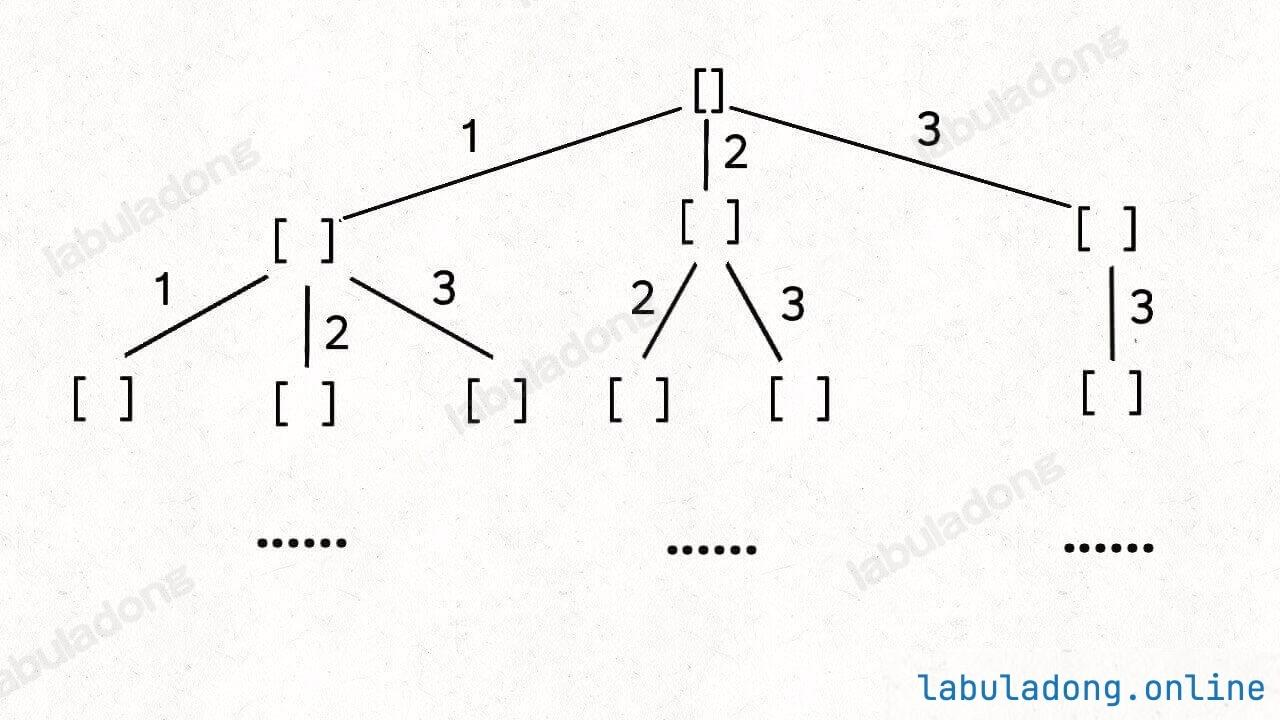

整数分解结果的枚举

In [ ]:
import sys
sys.setrecursionlimit(10**7)
class Solution:
    def breakN(self, n):
        res = []
        track = []
        def dfs(num, start):
            for i in range(start,num+1):
                if num % i == 0:
                    track.append(i)
                    if num//i == 1:
                        track.sort()
                        res.append(track.copy())
                    dfs(num//i, i)
                    track.pop()
        dfs(n, 2)
        return res
def main():
    n = int(input().strip())

    sol = Solution()
    res = sol.breakN(n)
    res.sort()
    for i in range(len(res)):
        print(str(n) + "="+"*".join(map(str,res[i])))

if __name__ == "__main__":
    main()

## 9.动态规划

### 0.通用方法！
数学推导五步法
1. 构造集合：从具体例子出发，列出所有情况
2. 寻找等式：根据集合元素中上一个位置的取值进行集合划分 
3. 集合映射：去掉集合元素的最后一个元素，集合映射为子问题形式 
4. 推广得到递推式 
5. 列举边界情况 

### 1.例题：最大连续子数组和

1. 从具体简单例子出发，枚举所有情况
2. 寻找等式：根据集合元素中上一个位置的取值进行集合划分 

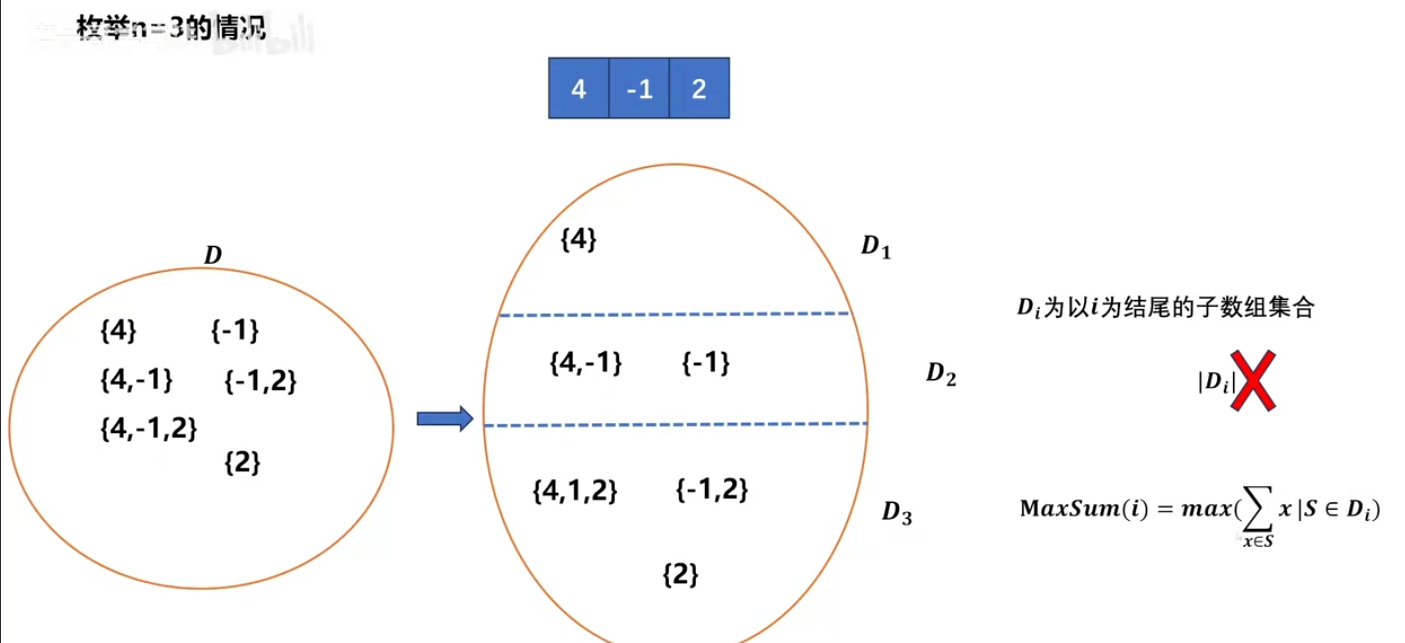

3. 集合映射：去掉集合元素的最后一个元素，集合映射为子问题形式

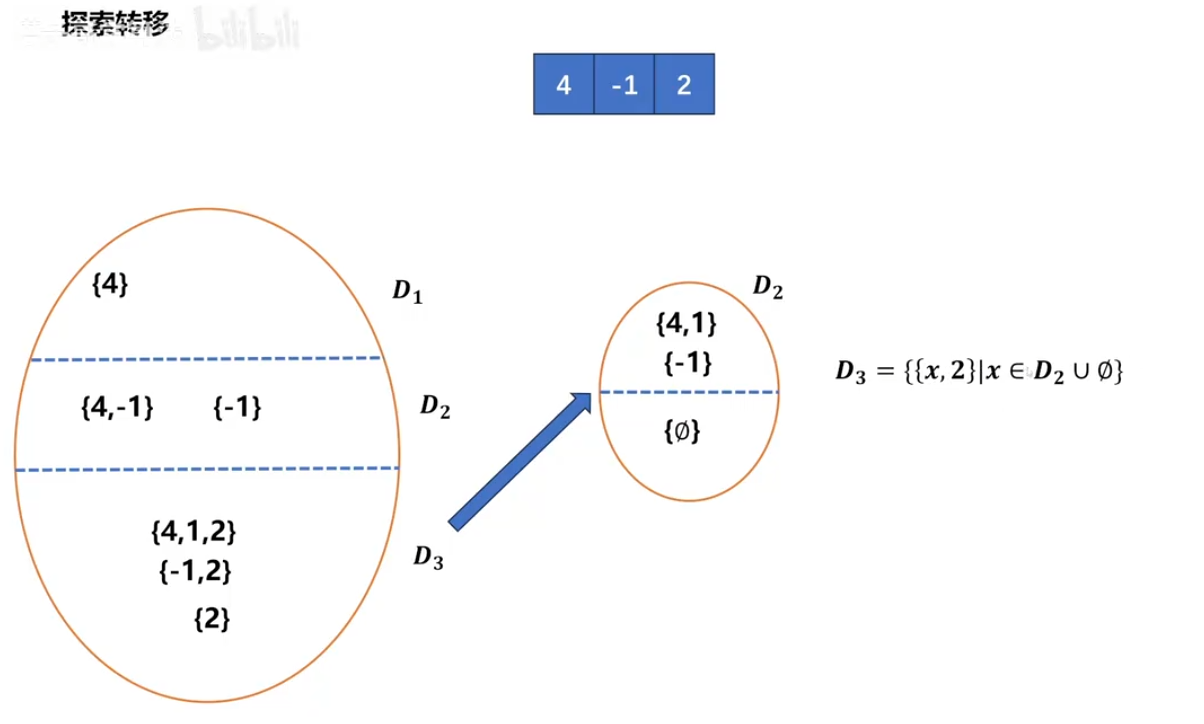

4. 推广得到递推式 

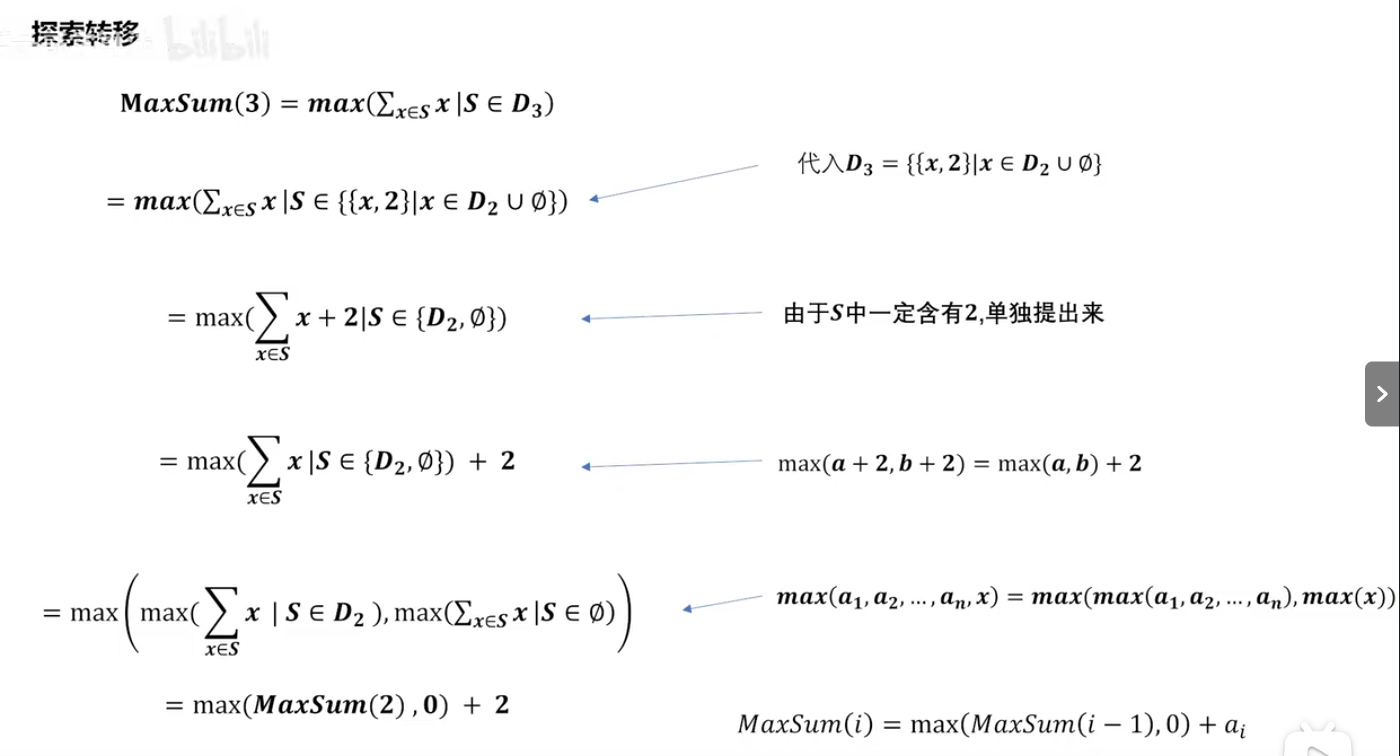

5. 列举边界情况

MAX[1]=max(0,a[1])

In [ ]:
# 完整代码:
class Solution:
    def maxSubArray(self, nums):
        # 初始化最大子数组和为最小值，当前子数组和为0
        maxSum = float('-inf')
        currentSum = [0]*len(nums)    # 进一步的优化是用一个变量代替数组 就是currentSum不断变化来遍历所有--优化空间
        currentSum[0] = max(nums[0],0)

        for i in range(1,len(nums)):
            # 计算当前最大子数组和
            currentSum[i] = max(0, currentSum[i-1])+nums[i]
            # 更新全局最大子数组和
            maxSum = max(maxSum, currentSum[i])

        return maxSum

if __name__ == "__main__":
    # 读取输入
    n = int(input().strip())
    nums = list(map(int, input().split()))
    
    # 计算最大子数组和并输出
    solution = Solution()
    print(solution.maxSubArray(nums))


### 1.背包问题

#### 怎么判断倒叙还是正序dp

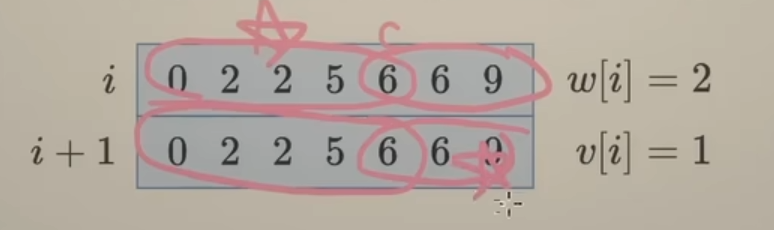
- 如果是由上述两个星星的地方转移到c(也就是6)的话就是倒叙

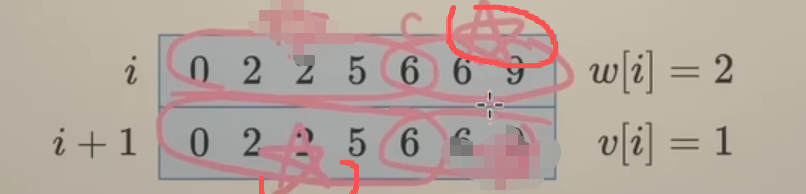
- 如果是由上述两个星星的地方转移到c(也就是6)的话就是正序

#### 1.01背包--不可重复选

n个物品,不可重复选

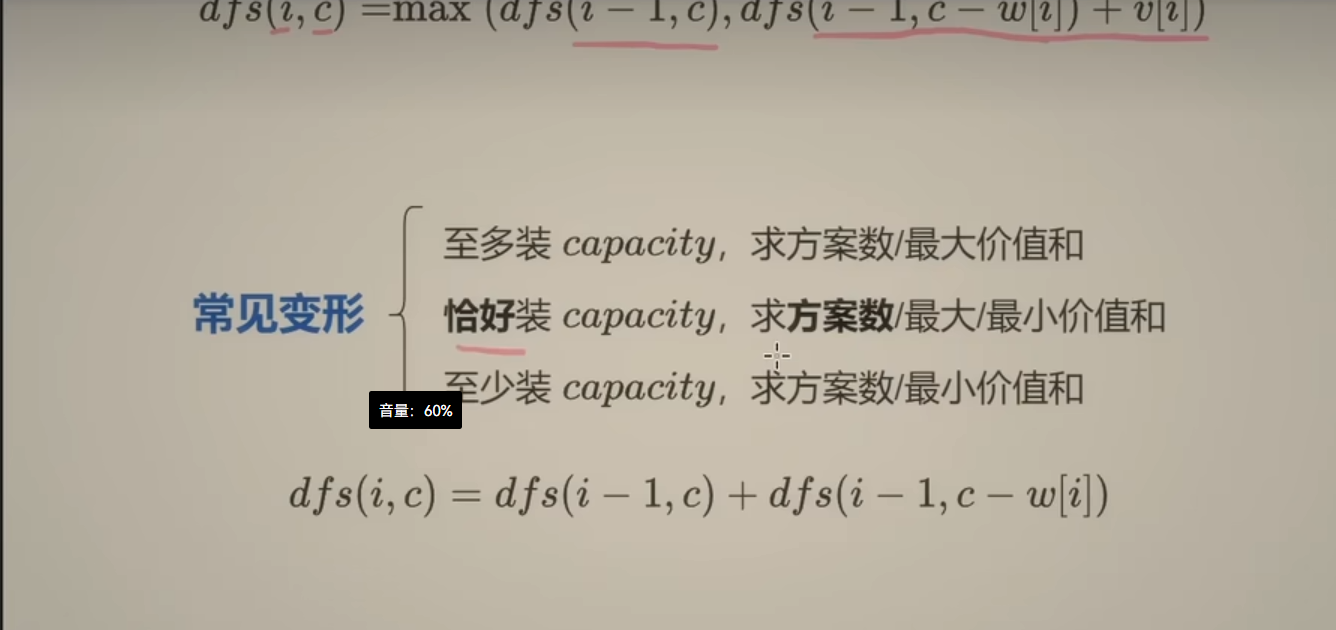

##### 1.固定子段和问题

先写出回溯的方法--再想办法变成分解问题的形式--再加一个@functools.cache

###### 核心思路



- 对于方法数问题递推关系直接相加:
``` python
dfs(i, remain) = dfs(i+1, remain - nums[i]) + dfs(i+1, remain)
```

- 然后递归的终止条件就是 i == n
分别赋予 
``` python
        if i == n:   # 递归终止条件
            if remain == 0:        # 判断到此方法是否可行
                return 1 # 可行--算一个方法
            return 0  # 不可行--不算
```

In [ ]:
# 记忆化搜索法
import functools

n = int(input().strip())
nums = list(map(int, input().strip().split()))


s = sum(nums)
if s%2:
    print(0)
else: 
    target = s//2

    @functools.cache
    def dfs(i, remain):
        if i == n:
            if remain == 0:        
                return 1
            return 0
        result = dfs(i+1, remain - nums[i]) + dfs(i+1, remain)
        return result
    print(dfs(0, target))
    





In [ ]:
# dp数组法
class Solution:
    def halfsum(self, nums):
        n = len(nums)
        allsum = sum(nums)
        if allsum % 2:
            return 0
        target = allsum//2

        dp = [[0]*(target+1) for _ in range(n+1)]
        dp[0][0] = 1
        for i, x in enumerate(nums):
            for c in range(target+1):
                if c < x:
                    dp[i+1][c] = dp[i][c]
                else:
                    dp[i+1][c] = dp[i][c] + dp[i][c-x]
        return dp[n][target]


def main():
    n = int(input().strip())
    nums = list(map(int, input().strip().split()))

    sol = Solution()
    print(sol.halfsum(nums))

if __name__ == "__main__":
    main()


# 进阶dp
import functools
class Solution:
    def halfsum(self, nums):
        n = len(nums)
        allsum = sum(nums)
        if allsum % 2:
            return 0
        target = allsum//2

        dp = [[0]*(target+1) for _ in range(2)]
        dp[0][0] = 1
        for i, x in enumerate(nums):
            for c in range(target+1):
                if c < x:
                    dp[(i+1)%2][c] = dp[i%2][c]
                else:
                    dp[(i+1)%2][c] = dp[i%2][c] + dp[i%2][c-x]
        return dp[n%2][target]


def main():
    n = int(input().strip())
    nums = list(map(int, input().strip().split()))

    sol = Solution()
    print(sol.halfsum(nums))

if __name__ == "__main__":
    main()
            

#### 2.完全背包--可重复选

n种物品可重复选---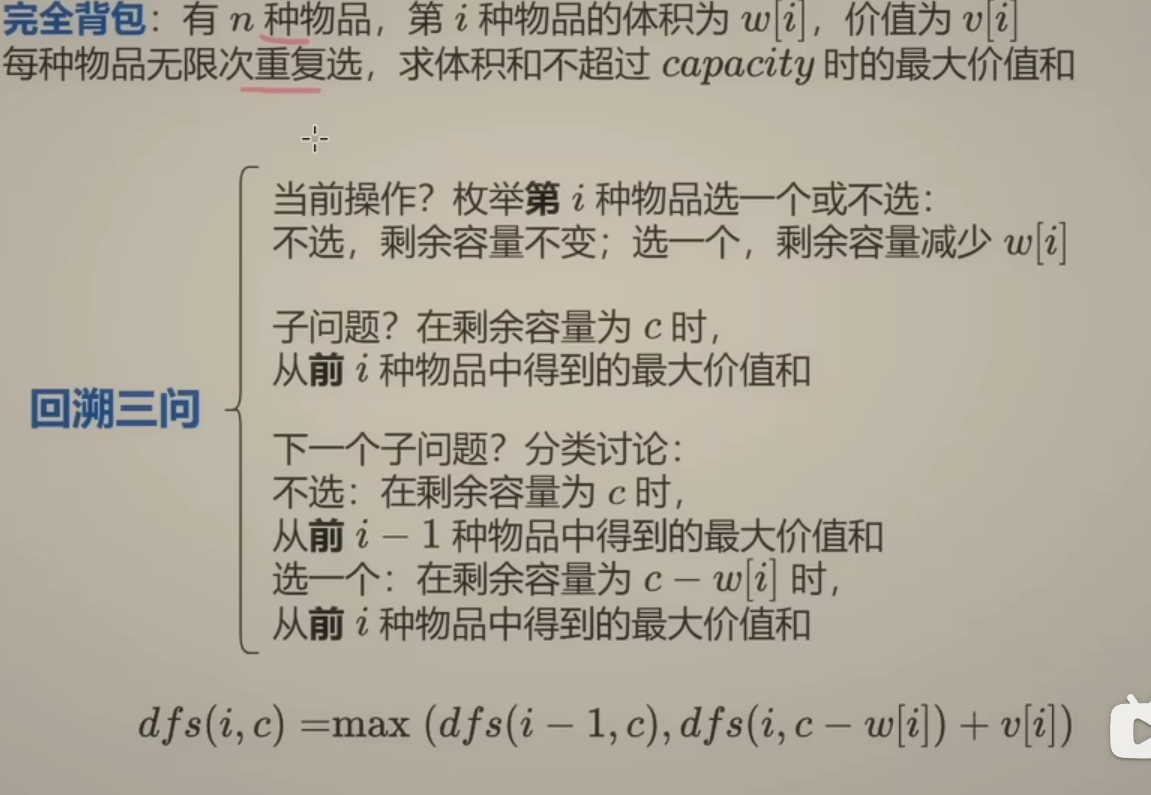

##### 1.零钱兑换

In [ ]:
import functools
import sys
sys.setrecursionlimit(10**7)
class Solution:
    def mincoins(self, nums, target):
        nums.sort(reverse = True)
        n = len(nums)

        #记忆化搜索写法
        @functools.cache
        def dfs(remain):
            if remain == 0:
                return 0
            res = float('inf')
            for coin in nums:
                if coin <= remain:
                    res = min(dfs(remain - coin)+1, res)
            return res

        return dfs(target)


        # dp数组写法
        # dp = [float("inf")] * (target+1)
        # dp[0] = 0
        # for i in range(target+1):
        #     for coin in nums:
        #         if coin <= i:
        #             dp[i] = min(dp[i], dp[i-coin]+1)
        # return dp[target] if dp[target] != float("inf") else -1





def main():
    nums = list(map(int, input().strip().split()))
    target = int(input().strip())

    sol = Solution()
    print(sol.mincoins(nums, target))

if __name__ == "__main__":
    main()

## 10.二分搜索

### 0.官方库自带的bisect模块


In [ ]:
from bisect import bisect_left, bisect_right # 注意 lo是下界，hi是上界 [lo, hi)
bisect_left(a, x, lo=0, hi=len(a)) # 寻找第一个大于等于x的元素 >=   存在=是左边界，不存在=其实是后驱所以要-1才是前驱
bisect_right(a, x, lo=0, hi=len(a)) # 寻找第一个大于x的元素 >  是后驱，如果要找最右边的元素可以用bisect_right(a, x, lo=0, hi=len(a))-1
# a 是数组,x是target, lo和hi是可选参数，表示搜索范围的起始和结束索引。

### 1.模板

#### 1.1 总模板

In [ ]:
def binarySearch(nums: List[int], target: int) -> int:
    left, right = 0, len(nums) - 1

    while ...:
        mid = left + (right - left) // 2
        if nums[mid] == target:
            ...
        elif nums[mid] < target:
            left = ...
        elif nums[mid] > target:
            right = ...
    return ...

#### 1.2 寻找一个数的模板

In [ ]:
class Solution:
    # 标准的二分搜索框架，搜索目标元素的索引，若不存在则返回 -1
    def search(self, nums: List[int], target: int) -> int:
        left = 0
        # 注意
        right = len(nums) - 1

        while left <= right:
            mid = left + (right - left) // 2
            if nums[mid] == target:
                return mid
            elif nums[mid] < target:
                # 注意
                left = mid + 1
            elif nums[mid] > target:
                # 注意
                right = mid - 1
        return -1

解惑：因为是闭区间
##### 为什么 while 循环的条件是 <= 而不是 <？  ---< 会漏掉 mid = left = right 的情况
- 因为初始化 right 的赋值是 nums.length - 1 当于两端都闭区间 [left, right]，while(left <= right) 的终止条件是 left == right + 1，写成区间的形式就是 [right + 1, right] 或者带个具体的数字进去 [3, 2]，可见这时候区间为空 ，如果是 left == right，那么 [left, right] 就会变成 [2, 2]，这时候区间不为空，还应该处理mid=2的情况，但此时不满足while(left <= right)，退出循环了所以就会漏掉mid=2的情况。

##### 为什么 left = mid + 1,right=mid - 1?
- 因为区间是两端都闭的,即 [left, right]。那么当我们发现索引 mid 不是要找的 target 时，下一步应该去搜索哪里呢？
- 当然是去搜索区间 [left, mid-1] 或者区间 [mid+1, right] 对不对？因为 mid 已经搜索过，应该从搜索区间中去除

##### 缺陷: 无法求左右界

#### 1.3 寻找左侧编边界的二分搜索

In [ ]:
def left_bound(nums: List[int], target: int) -> int:
    left = 0
    # 注意
    right = len(nums)
    
    # 注意
    while left < right:
        mid = left + (right - left) // 2
        if nums[mid] == target:
            right = mid
        elif nums[mid] < target:
            left = mid + 1
        elif nums[mid] > target:
            # 注意
            right = mid

    return left

解惑: 因为是开区间
##### 为什么 while 中是 < 而不是 <=？
因为 right = nums.length 而不是 nums.length - 1。因此每次循环的「搜索区间」是 [left, right) 左闭右开。

while(left < right) 终止的条件是 left == right，此时搜索区间 [left, left) 为空，所以可以正确终止。

##### target 不存在时返回什么？
答:直接说结论：如果 target 不存在，搜索左侧边界的二分搜索返回的索引是大于 target 的最小索引。

举个例子，nums = [2,3,5,7], target = 4，left_bound 函数返回值是 2，因为元素 5 是大于 4 的最小元素。

如果想让 target 不存在时返回 -1 其实很简单，在返回的时候额外判断一下 nums[left] 是否等于 target 就行了，如果不等于，就说明 target 不存在。需要注意的是，访问数组索引之前要保证索引不越界：

##### 为什么是 left = mid + 1 和 right = mid？
答：这个很好解释，因为我们的「搜索区间」是 [left, right) 左闭右开，所以当 nums[mid] 被检测之后，下一步应该去 mid 的左侧或者右侧区间搜索，即 [left, mid) 或 [mid + 1, right)

##### 为什么该算法能够搜索左侧边界？
答：关键在于对于 nums[mid] == target 这种情况的处理：
    if (nums[mid] == target)
        right = mid;
- 可见，找到 target 时不要立即返回，而是缩小「搜索区间」的上界 right，在区间 [left, mid) 中继续搜索，即不断向左收缩，达到锁定左侧边界的目的。


#### 1.4 寻找右侧边界的二分查找

In [ ]:
def right_bound(nums, target):
    left, right = 0, len(nums)
    while left < right:
        mid = left + (right - left) // 2
        if nums[mid] == target:
            # 注意
            left = mid + 1
        elif nums[mid] < target:
            left = mid + 1
        elif nums[mid] > target:
            right = mid
    # 注意
    return left - 1

解惑:
##### 为什么这个算法能够找到右侧边界？
答：类似地，关键点还是这里：


In [ ]:
if (nums[mid] == target) {
    left = mid + 1;
}
当 nums[mid] == target



 时，不要立即返回，而是增大「搜索区间」的左边界 left，使得区间不断向右靠拢，达到锁定右侧边界的目的



##### 为什么返回 left - 1？
为什么最后返回 left - 1 而不像左侧边界的函数，返回 left？而且我觉得这里既然是搜索右侧边界，应该返回 right 才对。

答：首先，while 循环的终止条件是 left == right，所以 left 和 right 是一样的，你非要体现右侧的特点，返回 right - 1 好了。

至于为什么要减一，这是搜索右侧边界的一个特殊点，关键在锁定右边界时的这个条件判断：

In [ ]:
// 增大 left，锁定右侧边界
if (nums[mid] == target) {
    left = mid + 1;
    // 这样想: mid = left - 1
}

因为我们对 left 的更新必须是 left = mid + 1，就是说 while 循环结束时，nums[left] 一定不等于 target 了，而 nums[left-1] 可能是 target。

至于为什么 left 的更新必须是 left = mid + 1，当然是为了把 nums[mid] 排除出搜索区间

### 2.模板统一!

#### 第一个，最基本的二分查找算法：

In [ ]:
因为我们初始化 right = nums.length - 1
所以决定了我们的「搜索区间」是 [left, right]
所以决定了 while (left <= right)
同时也决定了 left = mid+1 和 right = mid-1

因为我们只需找到一个 target 的索引即可
所以当 nums[mid] == target 时可以立即返回

#### 第二个，寻找左侧边界的二分查找：

因为我们初始化 right = nums.length
所以决定了我们的「搜索区间」是 [left, right)
所以决定了 while (left < right)
同时也决定了 left = mid + 1 和 right = mid

因为我们需找到 target 的最左侧索引
所以当 nums[mid] == target 时不要立即返回
而要收紧右侧边界以锁定左侧边界

#### 第三个，寻找右侧边界的二分查找

In [ ]:
因为我们初始化 right = nums.length
所以决定了我们的「搜索区间」是 [left, right)
所以决定了 while (left < right)
同时也决定了 left = mid + 1 和 right = mid

因为我们需找到 target 的最右侧索引
所以当 nums[mid] == target 时不要立即返回
而要收紧左侧边界以锁定右侧边界

又因为收紧左侧边界时必须 left = mid + 1
所以最后无论返回 left 还是 right，必须减一

### 总模板

In [ ]:
def binary_search(nums: List[int], target: int) -> int:
    # 设置左右下标
    left, right = 0, len(nums) - 1
    while left <= right:
        mid = left + (right - left) // 2
        if nums[mid] < target:
            left = mid + 1
        elif nums[mid] > target:
            right = mid - 1
        elif nums[mid] == target:
            # 找到目标值
            return mid
    # 没有找到目标值
    return -1

def left_bound(nums: List[int], target: int) -> int:
    # 设置左右下标
    left, right = 0, len(nums) - 1
    while left <= right:
        mid = left + (right - left) // 2
        if nums[mid] < target:
            left = mid + 1
        elif nums[mid] > target:
            right = mid - 1
        elif nums[mid] == target:
            # 存在目标值，缩小右边界
            right = mid - 1
    # 判断是否存在目标值
    if left < 0 or left >= len(nums):
        return -1
    # 判断找到的左边界是否是目标值
    return left if nums[left] == target else -1    

def right_bound(nums: List[int], target: int) -> int:
    # 设置左右下标
    left, right = 0, len(nums) - 1
    while left <= right:
        mid = left + (right - left) // 2
        if nums[mid] < target:
            left = mid + 1
        elif nums[mid] > target:
            right = mid - 1
        elif nums[mid] == target:
            # 存在目标值，缩小左边界
            left = mid + 1
    # 判断是否存在目标值
    if right < 0 or right >= len(nums):
        return -1
    # 判断找到的右边界是否是目标值
    return right if nums[right] == target else -1  

### 3.拓展核心:二分查找（包括二分答案）的核心是利用 “单调性” 收缩范围

### 一、先判断是否能用二分：抓 “单调性”

二分的前提是问题存在单调性—— 即 “当某个值 x 满足条件时，所有比 x 大（或小）的值也一定满足（或不满足）条件”。

比如防护服配送员题目：

若防护等级 x 能让配送员到达终点，则所有 ≥x 的等级都能到达（因为等级越高，能通过的格子越多）。

若 x 不能到达，则所有 ≤x 的等级都不能到达。

这种 “非降” 的单调性，就是二分答案的基础。

### 二、固定步骤：3 步走

#### **步骤1：确定二分的“边界”（left 和 right）**
边界必须覆盖**所有可能的答案**，且尽可能精确（减少循环次数）。  
- **左边界（left）**：最小可能的答案。  
  比如你的题，防护等级至少要覆盖起点和终点，所以 `left = max(grid[0][0], grid[n-1][n-1])`。  
- **右边界（right）**：最大可能的答案。  
  比如你的题，最大等级不可能超过网格中最大的辐射值（否则没必要），所以 `right = 网格中所有元素的最大值`。  

**避坑点**：  
- 左边界不能太小（比如不能小于问题的“必要条件”，如你的题中不能小于起点/终点的辐射值）。  
- 右边界不能太大（但宁可大一点，也别漏了可能的答案，比如极端情况可设为 `1e9` 这种上限）。  


#### **步骤2：编写“验证函数”（check(mid)）**
作用：判断当前中间值 `mid` 是否满足条件（比如“防护等级为 `mid` 时，能否在 `k` 步内到达终点”）。  
这一步是二分的“灵魂”，需要根据题目场景实现（你的题用 BFS，其他题可能用 DFS、数学计算等）。  

**验证函数的核心逻辑**：  
- 输入：候选值 `mid`。  
- 输出：`True`（满足条件）或 `False`（不满足）。  

比如你的 `validprotect` 函数，就是典型的验证函数：检查 `mid` 等级下能否到达终点

#### **步骤3：二分循环收缩范围**
目标：通过不断缩小 `[left, right]` 范围，找到**最小的满足条件的值**（或最大的，根据题目调整）。  

**循环模板（求“最小满足条件的值”）**：  


In [ ]:
while left < right:  # 当范围还没收缩到一个值时
    mid = (left + right) // 2  # 取中间值
    if check(mid):  # 若mid满足条件
        # 尝试找更小的满足条件的值，收缩右边界
        right = mid
    else:  # 若mid不满足条件
        # 必须增大mid才能满足，收缩左边界
        left = mid + 1
# 循环结束时，left == right，就是答案
return left

**关键细节**：  
1. **循环条件用 `left < right`**：最终会收敛到 `left = right`，直接返回即可。  
2. **`mid` 的计算**：`(left + right) // 2` 是整数除法，在 Python 中无需担心溢出（其他语言可能用 `left + (right - left) // 2` 避免溢出）。  
3. **调整边界的逻辑**：  
   - 若 `check(mid)` 为 `True`：说明 `mid` 可行，且可能有更小的可行值，因此 `right = mid`（保留 `mid` 继续尝试更小的）。  
   - 若 `check(mid)` 为 `False`：说明 `mid` 不可行，必须找更大的值，因此 `left = mid + 1`（排除 `mid`，因为它肯定不行）。  

### **三、最容易踩的坑及解决**

1. **边界初始化错误**  
   - 比如你的题中，若 `left` 设为网格的最小值（小于起点辐射值），则会包含无效值，导致二分结果错误。  
   - 解决：**先明确答案的“必要条件”**（如必须覆盖起点），用必要条件定左边界。  

2. **验证函数逻辑错误**  
   - 比如 BFS 中漏判边界、步数计算错误、访问标记反了（把 `not visited` 写成 `visited`）。  
   - 解决：单独测试验证函数，用简单样例（如样例1）检查是否能正确返回 `True` 或 `False`。  

3. **调整边界时漏加1**  
   - 比如当 `check(mid)` 为 `False` 时，写成 `left = mid` 而非 `left = mid + 1`，会导致死循环（比如 `left=2, right=3` 时，`mid=2` 不满足，若 `left` 不变，下次循环还是 `mid=2`）。  
   - 解决：记住“不满足就加1”，因为 `mid` 已经被证明无效，无需保留。  

4. **循环结束后没判断**  
   - 某些场景下（如答案可能不存在），需要最后检查 `left` 是否真的满足条件。但你的题中题目明确说“有解”，所以可直接返回。  

### **四、实战总结：用你的题套模板**
1. **单调性**：防护等级越高，越容易到达终点（满足二分）。  
2. **边界**：  
   - `left = max(起点, 终点)`（必要条件）。  
   - `right = 网格最大值`（最大可能值）。  
3. **验证函数**：BFS 检查 `mid` 等级下能否在 `k` 步内到达终点。  
4. **二分循环**：用 `while left < right`，满足则 `right=mid`，不满足则 `left=mid+1`，最终返回 `left`。

In [ ]:
import sys
from collections import deque
class Solution:
    def defendlevel(self,grid,k):
        n = len(grid)
        res = max(grid[0][0],grid[n-1][n-1])
        minlevel, maxlevel = res, res 
        for i in range(n):
            #minlevel = min(minlevel, min(grid[i]))
            maxlevel = max(maxlevel, max(grid[i]))
        mid = (minlevel + maxlevel)//2
        while minlevel < maxlevel:
            mid = (minlevel+maxlevel)//2
            if self.validprotect(grid,k,mid):
                maxlevel = mid 
            else:
                minlevel = mid +1          
        return maxlevel

    def validprotect(self,grid,k,plevel):
            n = len(grid)
            if grid[0][0] > plevel or grid[n-1][n-1] > plevel:
                return False
            visited = [[False]*n for _ in range(n)]
            q = deque()
            q.append((0,0,k))
            directions = [(-1,0), (1,0), (0,-1), (0,1)]
            while q:
                x, y, rs = q.popleft()
                for dx, dy in directions:
                    nx, ny = x+dx, y+dy
                    if 0 <= nx < n and 0 <= ny < n and (rs-1) >= 0 and not visited[nx][ny] and grid[nx][ny] <= plevel:
                        if nx == (n-1) and ny == (n-1):
                            return True
                        q.append((nx, ny, rs-1))
                        visited[nx][ny] = True
            return False




if __name__ == "__main__":
    input = sys.stdin.readline
    n = int(input().strip())
    k = int(input().strip())
    grid = [[]for _ in range(n)]
    for i in range(n):
        grid[i] = list(map(int, input().strip().split()))
    solution = Solution()
    print(solution.defendlevel(grid,k))
    

## 11.二分答案

答案越大越难达成，或者答案越小越难达成,只要答案即具有单调性,那就可以用二分答案来解决

二分的横坐标是答案。 而原先二分搜索的横坐标通常是数组下标

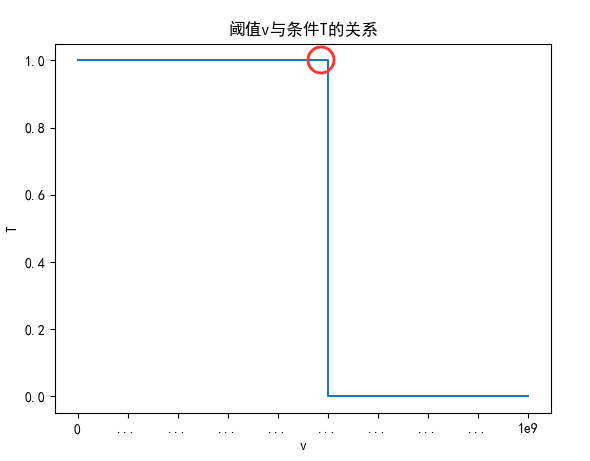

购物系统的降级策略
- 给你一个数组R，寻找一个最大的阈值v，满足条件T: $$\sum \min(R_i, v) \leq cnt$$

In [ ]:
class Solution:
    def maxvalue(self, nums, cnt):
        def check(v):
            s = 0
            for x in nums:
                s += min(x,v) 
            return s <= cnt
        m = max(nums)
        l, r = 0, m
        while l <= r:
            v = l + r >> 1
            if check(v):
                l = v+1
            else:
                r = v-1
        if r == m:
            return -1
        return r


if __name__ == "__main__":
    nums = list(map(int, input().strip().split()))
    cnt = int(input())
    solution = Solution()
    print(solution.maxvalue(nums, cnt))


二分答案法是算法中一种高效的解题思路，核心是**利用答案的单调性**和**可验证性**来快速锁定最优解。它的适用场景和使用步骤可以归纳为以下内容：


### 一、什么时候用二分答案法？
核心条件有两个：  
1. **答案具有单调性**（最关键）  
   即：如果某个值 `x` 是问题的可行解，那么所有**小于 `x` 的值**（或所有**大于 `x` 的值**）也一定是可行解。  
   - 例1：求“最多能凑多少套砖块”（如你之前的题目）。若能凑出 `m` 套，则 `m-1` 套一定也能凑出（减少一套需求，显然更容易满足），这就是“答案越大越难，越小越容易”的单调性。  
   - 例2：求“最小的 `x` 使得某个条件成立”（如“找到最小的时间让所有人完成任务”）。若 `x` 可行，则 `x+1` 一定也可行（时间更充裕，显然更容易满足），这是“答案越小越难，越大越容易”的单调性。  

2. **可验证性**  
   对于一个候选答案 `mid`，能在**较短时间内**（通常是 `O(1)` 或 `O(n)` 复杂度）判断它是否为可行解（即是否满足问题的条件）。  


### 二、二分答案法的通用步骤
#### 步骤1：确定答案的「范围」（上下界）  
   首先明确答案可能存在的区间 `[left, right]`：  
   - `left`：答案的最小可能值（通常是0或问题的物理最小值）；  
   - `right`：答案的最大可能值（通常是问题中数据的上限，如 `1e18` 或输入的最大值）。  

   例：在“最多凑多少套砖块”中，答案最小是0，最大不可能超过初始单种砖块的数量也就是1e9。  


#### 步骤2：设计「验证函数」（check函数）  
   核心是判断：对于候选答案 `mid`，是否能通过题目的规则（如合成、操作）满足 `mid` 的需求。  
   - 验证函数的复杂度必须足够低（否则二分后总复杂度会过高）。  

   例：在砖块问题中，`check(mid)` 的逻辑是：  
     1. 先判断红砖是否足够 `mid` 个，若多余则合成蓝砖；  
     2. 再判断蓝砖是否足够 `mid` 个，若多余则合成绿砖；  
     3. 最后检查红砖、蓝砖、绿砖是否都不少于 `mid` 个。  


#### 步骤3：二分查找最优解  
   根据单调性，通过二分不断缩小范围，找到“最大可行解”或“最小可行解”：  
   - 若目标是**最大可行解**（如“最多多少套”）：  
     - 若 `check(mid)` 可行，则说明可以尝试更大的答案，更新 `left = mid`；  
     - 若不可行，则必须尝试更小的答案，更新 `right = mid - 1`；  
     - 初始 `left=0`，`right=最大值`，二分终止时 `left` 即为答案。  

   - 若目标是**最小可行解**（如“最小时间”）：  
     - 若 `check(mid)` 可行，则说明可以尝试更小的答案，更新 `right = mid`；  
     - 若不可行，则必须尝试更大的答案，更新 `left = mid + 1`；  
     - 初始 `left=最小值`，`right=最大值`，二分终止时 `right` 即为答案。  


### 三、典型例题场景  
二分答案法在以下场景中非常常见：  
1. 资源分配问题（如“最多能满足多少需求”“最少需要多少资源”）；  
2. 最大化/最小化某个指标（如“最长的最短距离”“最小的最大时间”）；  
3. 存在“合成/转换”规则的问题（如砖块合成、能量转换等）；  
4. 无法直接计算答案，但能验证答案的问题（如“判断某个值是否满足条件”比“直接求这个值”容易）。  


### 四、关键注意点  
1. **单调性是前提**：如果答案不满足单调性（如“可行解和不可行解交替出现”），则不能用二分答案法。  
2. **边界处理**：二分的 `mid` 计算（如 `(left + right + 1) // 2` 避免死循环）和范围更新需要仔细处理，否则可能错过最优解。  
3. **验证函数的效率**：二分的总复杂度是 `O(log(范围) * 验证复杂度)`，若验证函数太慢（如 `O(n^2)`），即使二分也会超时。  


### 总结  
二分答案法的核心是“化繁为简”：将“求最优解”转化为“验证某个解是否可行”，再利用单调性通过二分快速锁定最优解。只要问题满足“单调性”和“可验证性”，它就是比暴力枚举高效得多的选择（通常从 `O(1e18)` 降到 `O(60)` 级别）。

## 12. 排序算法

### 0.封装好的常用排序函数

#### 1.堆排序！

In [6]:
import heapq
pq = []
heapq.heappush(pq, (5, 'b'))   # 对(n,m)元组，先按n排序，n相同按m排序
heapq.heappush(pq, (5, 'a'))   # 如果想降序，则把元组中的第一个元素改为-n 
heapq.heappush(pq, (1, 'c'))
while pq:
    next_item = heapq.heappop(pq)
    print(next_item)

(1, 'c')
(5, 'a')
(5, 'b')


#### 2.列表排序(lambda 函数)
```python
list.sort(key=None, reverse=False)
```
False表示升序（默认），True表示降序

In [8]:
a = [(5, 'b'), (5, 'a'), (1, 'c')]
a.sort(key = lambda x : (-ord(x[1]) , x[0])) # 先按第二个元素降序，第二个元素相同按第一个元素升序
print(a)  # 注意对于字符要先ord()才能用-+运算

[(1, 'c'), (5, 'b'), (5, 'a')]


#### 复杂用法:

 要理解 events.sort(key=lambda x: (x[0], x[1])) 的语法和作用，我们可以拆成几个部分来解释：
##### 1. 先看 lambda x: (x[0], x[1]) 是什么？
- lambda 是 Python 中定义匿名函数的关键字，它的作用是快速创建一个简单的函数。

- 这里的 lambda x: (x[0], x[1]) 可以理解为：
输入一个参数 x（可以是任何变量名，这里用 x 只是习惯）；
返回一个元组 (x[0], x[1])，也就是取 x 的第 0 个元素和第 1 个元素，组成一个新的元组。
##### 2. x 代表什么？
- x 是 events 列表中的每个元素。

在我们的场景中，events 是一个由元组组成的列表，比如：
[(1, +1), (2, -1), (1, +1), (3, -1)]
这里的每个元组 (时间, 变化量) 就是 x。例如：
当遍历到第一个元素 (1, +1) 时，x 就是 (1, +1)；
当遍历到第二个元素 (2, -1) 时，x 就是 (2, -1)。
##### 3. x[0] 和 x[1] 代表什么？
由于 x 是一个二元组 (时间, 变化量)，所以：
x[0] 表示元组的第一个元素（时间值，比如 1、2、3 等）；
x[1] 表示元组的第二个元素（变化量，即 +1 或 -1）。
##### 4. 为什么用 key=lambda x: (x[0], x[1]) 来排序？
sort 方法的 key 参数用于指定排序的依据。简单说：
先按照 x[0]（时间）从小到大排序；
如果两个元素的 x[0]（时间）相同，再按照 x[1]（变化量）从小到大排序。


#### 1.冒泡排序

In [2]:
# 进一步优化，数组有序时提前终止算法
def sort(nums):
    n = len(nums)
    sorted_index = 0
    while sorted_index < n:
        # 加一个布尔变量，记录是否进行过交换操作
        swapped = False
        for i in range(n - 1, sorted_index, -1):
            if nums[i] < nums[i - 1]:
                # swap(nums[i], nums[i - 1])
                tmp = nums[i]
                nums[i] = nums[i - 1]
                nums[i - 1] = tmp
                swapped = True
        # 如果一次交换操作都没有进行，说明数组已经有序，可以提前终止算法
        if not swapped:
            break
        sorted_index += 1

## 13.枚举

### 1.二进制枚举

二进制枚举是一种通过二进制数的每一位表示“元素是否被选中”，从而枚举所有可能子集的算法思想。它的核心是用**二进制位的状态**（0或1）对应“不选”或“选”，通过遍历所有二进制数覆盖所有子集情况。




#### 一、二进制枚举通用模板（Python）



```python
def binary_enum(elements):
    n = len(elements)  # 元素数量
    max_mask = 1 << n  # 总子集数：2^n（左移n位等价于2^n）没一位可以选择0或1（表示选与不选）
    best_result = 0  # 用于记录最优结果（根据问题调整）
    
    for mask in range(max_mask):  # 遍历所有子集（mask为二进制掩码）
        selected = []  # 存储当前子集中被选中的元素
        current_value = 0  # 当前子集的指标值（根据问题调整）
        
        # 检查每个元素是否被选中
        for j in range(n):
            if (mask >> j) & 1:  # 第j位为1 → 选中第j个元素
                selected.append(elements[j])
                # 累加/计算当前元素对指标的贡献（根据问题调整）
                current_value += elements[j]  # 示例：累加元素值
        
        # 检查当前子集是否满足约束（根据问题调整）
        if is_valid(selected):  # 自定义约束检查函数
            # 更新最优结果（根据问题调整，如最大化/最小化）
            best_result = max(best_result, current_value)
    
    return best_result

# 示例约束检查函数（根据具体问题实现）
def is_valid(selected):
    # 例如：选中元素的和不超过100
    return sum(selected) <= 100
```




#### 二、模板核心组件解析



1. **掩码（mask）**：  
   整数`mask`的二进制表示中，第`j`位为`1`表示“选中第`j`个元素”，为`0`表示“不选”。例如`mask=5`（二进制`101`）表示选中第0个和第2个元素。

2. **遍历范围**：  
   从`0`到`2^n - 1`（即`0`到`(1<<n)-1`），覆盖所有可能的子集（包括空集）。

3. **元素筛选**：  
   通过位运算`(mask >> j) & 1`判断第`j`个元素是否被选中（右移`j`位后与1取与，结果为1则选中）。

4. **约束检查与指标计算**：  
   对选中的元素子集，检查是否满足问题约束（如“不超载”“和为特定值”等），并计算其指标（如“利用率”“和”等），最终更新最优结果。




#### 三、应用场景
二进制枚举适用于**元素数量较少（通常n≤20）** 且需要**枚举所有可能子集**的问题，典型场景包括：



##### 1. 组合优化问题  
需要从n个元素中选择子集，满足约束条件，并最大化/最小化某个指标。  
- 例：火车座位安排（本文题目）：从x个乘客中选子集，确保任意时刻人数≤座位数，最大化总利用率。  
- 例：0-1背包问题（n较小时）：从物品中选子集，总重量≤背包容量，最大化总价值。




##### 2. 子集合法性检查  
判断是否存在满足特定条件的子集（或计数符合条件的子集数量）。  
- 例：是否存在一个子集，元素和为k？  
- 例：统计所有子集中和为偶数的数量。




##### 3. 穷举所有可能的选择  
问题需要覆盖所有“选/不选”的组合，且无更高效的解法（如状态压缩DP不适用时）。  
- 例：列举n盏灯的所有开关状态（每盏灯开/关对应选/不选）。  
- 例：从n个数字中选任意个，计算所有可能的乘积。




#### 四、注意事项



1. **复杂度限制**：  
   时间复杂度为`O(2^n * n)`（遍历2^n个子集，每个子集检查n个元素），因此**n必须较小**（通常n≤20，2^20≈1e6；n=30时2^30≈1e9，会超时）。

2. **灵活性**：  
   可通过调整“约束检查”和“指标计算”部分，适配不同问题（无需改变枚举框架）。

3. **与回溯法的对比**：  
   二进制枚举代码更简洁（无需递归），但本质与回溯法一致（均枚举所有子集），适合n较小的场景；n较大时需用动态规划等优化。


通过掌握这个模板，你可以快速解决各类“子集选择”问题，核心是用二进制掩码覆盖所有可能，再结合约束和指标计算得到最优解。

## 14.优化方法

### 1.分治优化DFS--中途相遇法


#### 一、基础概念



##### 1. 定义
中途相遇法是一种**分治思想的延伸算法**，核心是将一个“无法直接暴力求解的大问题”拆分为两个（或多个）“可暴力求解的小问题”，分别计算两个小问题的所有可能结果，再通过“高效匹配”合并结果，最终得到原问题的解。



##### 2. 核心目标
解决 **“指数级复杂度爆炸”** 问题：当问题规模为 `n` 时，暴力解法复杂度为 `O(2^n)`（如子集枚举），中途相遇法可将复杂度降至 `O(2^(n/2) + 2^(n/2)log2^(n/2))`，使 `n=40` 等中等规模问题可解。




#### 二、适用场景（必记！）



##### 1. 核心适用场景
- **问题类型**：**子集和类问题**（如 01 背包最大价值、预算内最大工作量、是否存在子集和等于目标值等）。
- **数据范围**：`n` 通常在 **30~40 之间**（`2^20≈1e6` 可控，`2^40≈1e12` 不可控）。
- **排除动态规划的场景**：当动态规划的“状态维度”过大时（如 01 背包中 `T≤1e9`，无法用 `dp[T]` 存储状态）。



##### 2. 不适用场景
- 子问题不独立（如 N 皇后问题，后半段状态依赖前半段）；
- 非子集选择类问题（如二叉树路径和、图的最短路径）；
- `n≤20`（普通 DFS 已足够高效，无需拆分）。




#### 三、核心原理（3步拆解）
以“子集和最大值问题”（给定数组 `nums` 和目标 `T`，找子集和 ≤T 的最大值）为例，原理如下：
1. **分治拆分**：将数组 `nums` 均分为两组 `A` 和 `B`（如 `n=40` 拆为 `20+20`），确保每组规模 ≤20；
2. **枚举子集和**：分别生成两组的**所有可能子集和**（包括空集，空集和为 0）；
3. **高效合并**：对其中一组的子集和排序，遍历另一组的每个子集和 `s`，在排序后的子集和中找“≤T-s”的最大值 `s'`，`s+s'` 即为候选解，最终取所有候选解的最大值。




#### 四、解题模版（通用版）



##### 1. 模版步骤（4步固定流程）



##### 步骤1：拆分数组
将原数组 `nums` 均分为两组（尽量均分，减少子集和数量）：
- 拆分点 `mid = len(nums) // 2`；
- 第一组 `group1 = nums[:mid]`（前半段）；
- 第二组 `group2 = nums[mid:]`（后半段）。



##### 步骤2：生成子集和（关键！）
实现一个通用函数，生成任意数组的所有子集和（两种实现方式，选其一即可）：
- **方式1：DFS 递归（易理解）**：通过“选/不选”分支枚举所有子集；
- **方式2：二进制掩码（高效）**：用 `mask`（二进制数）表示子集，`mask` 的第 `i` 位为 1 表示选第 `i` 个元素。



##### 步骤3：排序优化
对第二组的子集和排序（为后续二分查找做准备，排序一次即可）。



##### 步骤4：合并查找最优解
遍历第一组的每个子集和 `s1`，计算剩余预算 `remaining = T - s1`，通过二分查找在第二组子集和中找“≤remaining”的最大 `s2`，更新 `max_total = max(max_total, s1+s2)`。




##### 2. 通用代码模版（Python）


In [ ]:
import bisect  # 用于二分查找

class MeetInTheMiddleTemplate:
    def solve(self, nums, T):
        """
        中途相遇法通用求解函数（以“子集和≤T的最大值”为例）
        :param nums: 输入数组（如需求工作量列表）
        :param T: 目标值（如预算）
        :return: 满足条件的最大值
        """
        n = len(nums)
        if n == 0:
            return 0
        
        # -------------------------- 步骤1：拆分数组 --------------------------
        mid = n // 2
        group1 = nums[:mid]  # 前半组（最多20个元素）
        group2 = nums[mid:]  # 后半组（最多21个元素，n=40时为20个）
        
        # -------------------------- 步骤2：生成子集和 --------------------------
        def generate_subset_sums(arr):
            """生成数组的所有子集和（两种实现方式选其一）"""
            # 方式1：DFS递归（易理解，适合新手）
            subset_sums = []
            def dfs(index, current_sum):
                if index == len(arr):
                    subset_sums.append(current_sum)
                    return
                dfs(index + 1, current_sum)  # 不选当前元素
                dfs(index + 1, current_sum + arr[index])  # 选当前元素
            dfs(0, 0)
            return subset_sums
            
            # # 方式2：二进制掩码（高效，适合熟练者）
            # subset_sums = []
            # m = len(arr)
            # for mask in range(0, 1 << m):  # 1<<m = 2^m，遍历所有子集
            #     current_sum = 0
            #     for i in range(m):
            #         if mask & (1 << i):  # 第i位为1，选当前元素
            #             current_sum += arr[i]
            #     subset_sums.append(current_sum)
            # return subset_sums
        
        # 生成两组的子集和
        sums1 = generate_subset_sums(group1)
        sums2 = generate_subset_sums(group2)
        
        # -------------------------- 步骤3：排序优化（为二分查找） --------------------------
        sums1.sort()  # 可选：排序第一组，便于调试和理解
        sums2.sort()  # 仅需排序第二组
        
        # -------------------------- 步骤4：合并查找最优解 --------------------------
        max_total = 0
        for s1 in sums1:
            if s1 > T:  # 前半组和已超目标，后续s1更大，直接break
                break
            remaining = T - s1  # 后半组最多能贡献的和
            
            # 二分查找：找sums2中≤remaining的最大元素（bisect_right找插入点，减1即索引）
            idx = bisect.bisect_right(sums2, remaining) - 1
            if idx < 0:  # 无合法元素（仅当sums2为空，实际不会发生，因空集和为0）
                continue
            
            current_total = s1 + sums2[idx]
            if current_total > max_total:
                max_total = current_total
        
        return max_total


# -------------------------- 模版使用示例（对应“最大工作量问题”） --------------------------
if __name__ == "__main__":
    # 样例1输入
    n1, T1 = 5, 17
    nums1 = [2, 3, 5, 11, 7]
    solver = MeetInTheMiddleTemplate()
    print(solver.solve(nums1, T1))  # 输出17（正确）
    
    # 样例2输入
    n2, T2 = 6, 100
    nums2 = [1, 2, 7, 5, 8, 10]
    print(solver.solve(nums2, T2))  # 输出33（正确）
    
    # 样例3输入
    n3, T3 = 6, 100
    nums3 = [101, 102, 103, 104, 105, 106]
    print(solver.solve(nums3, T3))  # 输出0（正确）


#### 五、关键注意点（避坑指南）



1. **拆分数组时尽量均分**：  
   若 `n=40`，拆为 `20+20` 时，总子集和数量为 `2^20 + 2^20≈2e6`；若拆为 `10+30`，总数量为 `2^10 + 2^30≈1e9`（再次爆炸），因此必须均分。

2. **空集的作用不可忽略**：  
   子集和需包含空集（和为 0），否则会遗漏“只选前半组”或“只选后半组”的情况（如样例3中所有元素超预算，需选两组空集，和为 0）。

3. **二分查找的细节**：  
   用 `bisect.bisect_right` 而非 `bisect.bisect_left`，因为 `bisect_right` 能找到“第一个大于目标的元素”，减1后即为“≤目标的最大元素”（处理重复值更稳定）。

4. **需记录具体方案的调整**：  
   若题目要求输出“最优子集的具体构成”，只需在生成子集和时额外存储“元素索引/值”（如 `(sum, plan)`），合并时拼接两组的 `plan` 即可（参考之前的代码思路）。




#### 六、典型例题（巩固记忆）
1. **华为校招题：最大工作量**（已在模版示例中覆盖）；
2. **LeetCode 416. 分割等和子集**（变形：判断是否存在子集和等于总和的一半，中途相遇法可解）；
3. **LeetCode 1755. 最接近目标值的子序列和**（核心逻辑与中途相遇法一致，合并时找最接近目标的和）。



eg 1.最大工作量--我的解法

In [ ]:
import sys
import functools
sys.setrecursionlimit(10**7)
import bisect


class Solution:
    def maxneed(self, nums, T):
        n = len(nums)
        mid = n//2
        group1 = nums[:mid]
        group2 = nums[mid:]
        sum1 = []
        sum2 = []

        def dfs(group, sums, track, i):
            if i >= len(group):
                sums.append(track)
                return 
            # 选
            track += group[i]
            dfs(group, sums, track, i+1)
            track -= group[i]
            # 不选
            dfs(group, sums, track, i+1)

        dfs(group1, sum1, 0, 0)
        dfs(group2, sum2,0, 0)
        sum1.sort()
        sum2.sort()
        res = 0
        for sum1s in sum1:
            if sum1s > T:
                break
            remain = T - sum1s
            idx = bisect.bisect_right(sum2, remain) - 1
            res = max(res, sum1s + sum2[idx] )
        return res   



def main():
    n, T = map(int, input().strip().split())
    nums = list(map(int, input().strip().split()))

    sol = Solution()
    print(sol.maxneed(nums, T))

if __name__ == "__main__":
    main()


#### 七、总结
中途相遇法的核心是 **“分而治之，以空间换时间”**：  
- 用“存储两个小问题的所有结果”（空间复杂度 `O(2^(n/2))`），换取“避免枚举大问题的所有结果”（时间复杂度从 `O(2^n)` 降至 `O(2^(n/2)log2^(n/2))`）；  
- 牢记适用场景（子集和类 + n=30~40），直接套用“拆分→生成→排序→合并”的四步模版，即可高效解决问题。

# 一系列类型题目的标准解法

## 1. 一维覆盖问题

### 1.区间最大重叠数问题（连续--重叠）
最大区间重叠度问题

#### 其核心是：
给定多个区间（如时间区间、数值范围等），求解在某一时刻（或某一点）被最多区间同时覆盖的数量（即 “重叠度”）。

#### 常见应用场景
这类问题在实际中非常常见，本质都是同一类逻辑：
- 公交车座位问题：每个乘客的乘车时间是一个区间，最大重叠度就是最少需要的座位数。
- 会议室安排问题：每个会议的时间是一个区间，最大重叠度就是需要的最少会议室数量。
- 航班乘客数量：每个乘客的飞行时间是一个区间，最大重叠度就是某一时刻飞机上的最多乘客数。
- 网络带宽占用：每个任务的占用时间是一个区间，最大重叠度就是需要的最小带宽。

#### 核心解法
这类问题的经典解法是 **“事件点扫描法”**：
- 将每个区间[start, end]拆分为两个事件：(start, +1)（区间开始，重叠数 + 1）和(end, -1)（区间结束，重叠数 - 1）。
- 按事件点的位置排序（若位置相同，先处理结束事件-1，再处理开始事件+1，避免重复计算）。
- 扫描排序后的事件，实时更新当前重叠数，并记录最大值，即为 “最大重叠度”。
- 这种解法效率很高（时间复杂度O(n log n)，主要来自排序），是解决区间最大重叠问题的标准方案。

In [ ]:
def max_overlapping_intervals(intervals):
    """
    计算多个区间的最大重叠度（即最多有多少个区间同时覆盖同一个点）
    
    参数:
        intervals: 区间列表，每个区间为 [start, end] 形式（start < end）
        
    返回:
        int: 最大重叠度
    """
    # 处理空输入
    if not intervals:
        return 0
    
    # 1. 生成事件列表：将每个区间拆分为"开始事件"和"结束事件"
    events = []
    for start, end in intervals:
        # 开始事件：(位置, +1) 表示在该位置新增一个重叠区间
        events.append((start, 1))
        # 结束事件：(位置, -1) 表示在该位置减少一个重叠区间
        events.append((end, -1))
    
    # 2. 排序事件：
    #   - 先按位置升序排列
    #   - 位置相同时，结束事件(-1)排在开始事件(1)之前，避免重复计算
    events.sort(key=lambda x: (x[0], x[1]))
    
    # 3. 扫描事件，计算最大重叠度
    max_overlap = 0       # 记录最大重叠度
    current_overlap = 0   # 记录当前重叠度
    
    for position, delta in events:
        current_overlap += delta  # 更新当前重叠度
        # 实时更新最大重叠度
        if current_overlap > max_overlap:
            max_overlap = current_overlap
    
    return max_overlap


# 示例测试
if __name__ == "__main__":
    # 示例1：公交车座位问题
    bookings = [(1, 3), (2, 5), (4, 6)]
    print("公交车最大同时乘客数（最少座位数）：", max_overlapping_intervals(bookings))  # 输出：2
    
    # 示例2：会议室安排问题
    meetings = [(9, 10), (9, 12), (11, 13), (14, 15)]
    print("需要的最少会议室数量：", max_overlapping_intervals(meetings))  # 输出：2
    
    # 示例3：空输入
    print("空区间列表的最大重叠度：", max_overlapping_intervals([]))  # 输出：0
    
    # 示例4：重叠边界情况（同一时间点有开始和结束）
    intervals = [(1, 2), (2, 3), (2, 4)]
    print("边界重叠的最大重叠度：", max_overlapping_intervals(intervals))  # 输出：2


### 2.区间覆盖问题（连续--覆盖）
用最少数量的候选区间，尽可能完全覆盖一个给定的 “目标区间”（或覆盖最大可能的范围）。

#### 问题定义
- 输入：
一个 “目标区间” [T_start, T_end]（需要被覆盖的范围）；

一组候选区间 intervals = [[s1, e1], [s2, e2], ..., [sn, en]]（可选择的区间）。
- 输出：最少数量的候选区间，其并集能完全覆盖 [T_start, T_end]（若无法完全覆盖，则覆盖尽可能大的范围）。

#### 核心解决思路：贪心算法
区间覆盖问题具有 **“贪心选择性质”**：每次选择 “当前最优” 的区间（即能覆盖当前未覆盖部分且延伸最远的区间），最终能得到全局最优解（最少数量）。
#### 具体步骤：
1. 筛选有效区间
- 先过滤掉与目标区间完全无关的候选区间（即 ei < T_start 或 si > T_end 的区间，它们无法为覆盖目标区间做贡献）。
2. 排序候选区间
- 按区间的起点 s 升序排序（若起点相同，按终点 e 降序排序，优先保留覆盖范围更大的区间）。
3. 贪心选择区间
- 初始化：当前覆盖终点 = T_start（从目标区间的起点开始），选中的区间数 = 0，当前索引 = 0。
- 迭代选择：在所有起点 ≤ 当前覆盖终点的候选区间中，选择终点最大的区间（这样能覆盖最远的范围，减少后续需要的区间数量）。
- 更新状态：将 “当前覆盖终点” 更新为选中区间的终点，选中的区间数 += 1。
- 终止条件：若 “当前覆盖终点 ≥ T_end”，说明已完全覆盖目标区间，返回选中的区间数；若遍历完所有候选区间仍未覆盖，则返回 “已覆盖的最大范围” 和选中的区间数。

In [ ]:
def min_intervals_to_cover(target, intervals):
    """
    用最少数量的候选区间覆盖目标区间
    
    参数:
        target: 目标区间，格式为 [T_start, T_end]
        intervals: 候选区间列表，每个元素为 [s, e]（s < e）
    
    返回:
        元组 (covered, count)，其中：
            covered: 实际覆盖的区间 [start, end]
            count: 选中的区间数量（若无法完全覆盖，返回实际选中数）
    """
    T_start, T_end = target
    if T_start >= T_end:
        return (target, 0)  # 目标区间无效
    
    # 步骤1：筛选有效区间（与目标区间有交集）
    valid_intervals = []
    for s, e in intervals:
        # 排除完全在目标区间外的区间
        if e <= T_start or s >= T_end:
            continue
        # 裁剪区间到目标范围内（避免超出目标的部分干扰）
        clipped_s = max(s, T_start)
        clipped_e = min(e, T_end)
        valid_intervals.append((clipped_s, clipped_e))
    
    if not valid_intervals:
        return ((0, 0), 0)  # 无有效区间，无法覆盖
    
    # 步骤2：按起点升序排序，起点相同则按终点降序
    valid_intervals.sort(key=lambda x: (x[0], -x[1]))
    
    # 步骤3：贪心选择
    count = 0
    current_end = T_start  # 当前覆盖的终点
    max_reach = T_start    # 本轮能覆盖的最远距离
    i = 0
    n = len(valid_intervals)
    
    while current_end < T_end and i < n:
        # 找到所有起点 <= 当前覆盖终点的区间中，终点最大的那个
        while i < n and valid_intervals[i][0] <= current_end:
            if valid_intervals[i][1] > max_reach:
                max_reach = valid_intervals[i][1]
            i += 1
        
        if max_reach == current_end:
            # 没有找到能延伸覆盖范围的区间，无法继续覆盖
            break
        
        # 选中能覆盖最远的区间
        count += 1
        current_end = max_reach  # 更新当前覆盖终点
    
    # 实际覆盖的区间
    covered_start = T_start
    covered_end = current_end
    
    return ((covered_start, covered_end), count)


# 示例测试
if __name__ == "__main__":
    # 示例1：完全覆盖目标区间
    target1 = [1, 10]
    intervals1 = [[1, 3], [2, 6], [5, 7], [8, 10], [4, 9]]
    covered1, count1 = min_intervals_to_cover(target1, intervals1)
    print(f"目标区间{target1}：覆盖到{covered1}，最少需要{count1}个区间")  # 覆盖到(1,10)，需要4个
    
    # 示例2：无法完全覆盖
    target2 = [1, 20]
    intervals2 = [[1, 5], [3, 8], [10, 15]]
    covered2, count2 = min_intervals_to_cover(target2, intervals2)
    print(f"目标区间{target2}：覆盖到{covered2}，最少需要{count2}个区间")  # 覆盖到(1,15)，需要3个
    
    # 示例3：目标区间已被单个区间覆盖
    target3 = [5, 15]
    intervals3 = [[2, 20], [6, 10], [12, 18]]
    covered3, count3 = min_intervals_to_cover(target3, intervals3)
    print(f"目标区间{target3}：覆盖到{covered3}，最少需要{count3}个区间")  # 覆盖到(5,15)，需要1个


### 3.集合覆盖问题（离散--覆盖）
其核心是：给定一个 “全域集合”（如你例子中的 {1,2,3,4,5,6,7,8,9}）和一组 “子集”，从子集中选择最少数量的子集，使得它们的并集恰好等于全域集合（或覆盖全域中所有元素）。

#### 问题特点与挑战
经典 NP-hard 问题：集合覆盖问题没有多项式时间的精确算法（除非 P=NP），因此对于大规模问题，通常使用近似算法；对于小规模问题，可以用精确算法（如回溯、分支定界）。
核心目标：在 “覆盖所有元素” 的前提下，最小化选择的子集数量。

#### 解决思路
根据问题规模，有两种主要思路：
1. 贪心算法（近似解，适合大规模问题）;

贪心算法是集合覆盖问题最常用的近似解法，思路是 **“每次选择覆盖未覆盖元素最多的子集”**，重复直到覆盖所有元素。
- 优点：高效（时间复杂度O(n*m)，n是子集数量，m是全域元素数量），适合大规模场景。
- 缺点：不能保证找到最优解，但有严格的近似比（在最坏情况下，选择的子集数量不超过最优解的log(m)倍，m是全域元素数）。
2. 回溯 / 分支定界（精确解，适合小规模问题）：

对于子集数量较少（如小于 20）的场景，可以用回溯法枚举所有可能的子集组合，通过剪枝（如 “当前已选数量≥已知最优解时停止探索”）提高效率，找到最少子集数量。
- 优点：能找到最优解。
- 缺点：时间复杂度高（指数级），只适合小规模问题。

#### 回溯法
回溯法是一种通过枚举所有可能解并筛选最优解的算法，其核心思想是 “尝试所有选择，不行就退回上一步”。对于集合覆盖问题，回溯法能保证找到精确最优解（最少的子集数量），但时间复杂度较高，适合小规模问题。

##### 1.问题转化与预处理
- 问题目标：从子集列表中选择最少数量的子集，使它们的并集等于全域集合。
- 预处理优化：
过滤掉 “冗余子集”：如果子集 A 完全被子集 B 包含（A⊆B），则选择 A 不如选择 B（B 覆盖范围更大），可直接移除 A，减少搜索空间。
将所有元素转换为集合类型，便于计算交集、并集等操作。

##### 2.回溯法核心流程
回溯法通过递归实现，主要包含以下步骤：
回溯法通过递归实现，主要包含以下步骤：
1. 递归函数设计
2. 终止条件与剪枝
- 终止条件 1：若current_covered == target（已覆盖所有元素），则记录当前选择（若其数量少于已知最优解）。
- 剪枝条件 1：若len(current_selected) >= 已知最优解数量，则停止探索（继续下去不可能得到更优解）。
- 剪枝条件 2：若选择当前子集后，new_covered == current_covered（未增加覆盖元素），则跳过该子集（选择无意义）。
##### 3.递归探索
- 从start索引开始遍历所有子集（避免重复选择同一组合，如 [子集 1, 子集 2] 与 [子集 2, 子集 1] 视为同一组合）。
- 对每个子集，计算选择后的新覆盖范围new_covered。
- 选择该子集，递归探索下一个子集（索引i+1）。
- 回溯：移除当前子集，尝试其他选择。

In [ ]:
def backtrack_set_cover(universe, subsets):
    """
    回溯法求解集合覆盖问题（精确解）
    :param universe: 全域集合
    :param subsets: 子集列表（每个元素是集合）
    :return: 最优子集列表，及其数量
    """
    universe = set(universe)
    subsets = [set(s) for s in subsets]
    n = len(subsets)
    best_count = float('inf')  # 最优解的子集数量
    best_selection = []  # 最优解的子集
    
    def backtrack(start, current_selected, current_covered):
        nonlocal best_count, best_selection
        # 剪枝：如果当前已选数量≥已知最优解，无需继续
        if len(current_selected) >= best_count:
            return
        # 如果已覆盖所有元素，更新最优解
        if current_covered == universe:
            best_count = len(current_selected)
            best_selection = current_selected.copy()
            return
        # 尝试选择剩余的子集
        for i in range(start, n):
            s = subsets[i]
            new_covered = current_covered | s  #|运算符表示集合的并集操作
            current_selected.append(s)
            # 递归（从下一个子集开始，避免重复选择）
            backtrack(i + 1, current_selected, new_covered)
            current_selected.pop()  # 回溯
            '''
            current_covered 是 “新创建的集合”，而非 “修改原集合”，所以不需要回溯
            # 每次选择子集 s 时，不是修改原 current_covered，而是创建新集合
            new_covered = current_covered | s  # | 是并集运算，返回一个全新的集合
            # 递归时，传递的是这个新集合，而非原 current_covered
            backtrack(i + 1, current_selected, new_covered)
            '''
    backtrack(0, [], set())
    return best_selection, best_count if best_count != float('inf') else 0


# 测试你的例子
if __name__ == "__main__":
    universe = {1,2,3,4,5,6,7,8,9}
    subsets = [
        (1,2,3),
        (2,3,4),
        (6,7),
        (4,5,2,1),
        (2,3,6),
        (5,7,9),
        (8,)  # 补充包含8的子集
    ]
    
    best, count = backtrack_set_cover(universe, subsets)
    if best:
        print(f"回溯法找到的最优解（共{count}个）：")
        for s in best:
            print(s)
    else:
        print("无法完全覆盖全域元素")

In [ ]:
class Solution:
    def greedy_set_cover(self, universe, subsets):
        """贪心算法求解集合覆盖问题（近似解）"""
        # 转换为集合类型便于计算
        universe_set = set(universe)
        subset_sets = [set(subset) for subset in subsets]
        
        # 过滤掉完全不包含全域元素的子集
        valid_subsets = [s for s in subset_sets if s & universe_set]
        
        uncovered = universe_set.copy()  # 未覆盖的元素
        selected = []  # 选中的子集
        
        while uncovered:
            best_subset = None
            max_coverage = 0
            
            # 找到覆盖未覆盖元素最多的子集
            for subset in valid_subsets:
                coverage = len(subset & uncovered)
                if coverage > max_coverage:
                    max_coverage = coverage
                    best_subset = subset
            
            if max_coverage == 0:
                # 无法覆盖所有元素
                return None, 0
            
            # 选择该子集并更新未覆盖元素
            selected.append(best_subset)
            uncovered -= best_subset
            # 从候选集中移除已选子集（避免重复选择）
            valid_subsets.remove(best_subset)
        
        return selected, len(selected)
    
    def backtrack_set_cover(self, universe, subsets):
        """回溯法求解集合覆盖问题（精确解）"""
        universe_set = set(universe)
        subset_sets = [set(subset) for subset in subsets]
        n = len(subset_sets)
        
        self.best_count = float('inf')  # 最优解的子集数量
        self.best_selection = []  # 最优解的子集列表
        
        # 剪枝优化：预先过滤掉完全被其他子集包含的子集
        # 例如：若A⊆B，则选择B比选择A更优，可移除A
        filtered_subsets = []
        for i in range(n):
            is_redundant = False
            for j in range(n):
                if i != j and subset_sets[i].issubset(subset_sets[j]):
                    is_redundant = True
                    break
            if not is_redundant:
                filtered_subsets.append(subset_sets[i])
        
        # 递归回溯
        self._backtrack(
            start=0,
            current_selected=[],
            current_covered=set(),
            subsets=filtered_subsets,
            target=universe_set
        )
        
        if self.best_count != float('inf'):
            return self.best_selection, self.best_count
        else:
            return None, 0  # 无法覆盖所有元素
    
    def _backtrack(self, start, current_selected, current_covered, subsets, target):
        """回溯递归函数"""
        # 剪枝1：如果当前已选数量 >= 已知最优解，无需继续探索
        if len(current_selected) >= self.best_count:
            return
        
        # 剪枝2：如果已覆盖所有元素，更新最优解
        if current_covered == target:
            if len(current_selected) < self.best_count:
                self.best_count = len(current_selected)
                self.best_selection = current_selected.copy()
            return
        
        # 遍历剩余子集（从start开始，避免重复组合）
        for i in range(start, len(subsets)):
            subset = subsets[i]
            # 计算选择当前子集后新的覆盖范围
            new_covered = current_covered | subset
            
            # 剪枝3：如果新覆盖范围没有增加，跳过该子集
            if new_covered == current_covered:
                continue
            
            # 选择当前子集
            current_selected.append(subset)
            
            # 递归探索下一个子集（i+1确保不重复选择）
            self._backtrack(i + 1, current_selected, new_covered, subsets, target)
            
            # 回溯：移除当前子集，尝试其他选择
            current_selected.pop()


if __name__ == "__main__":
    # 测试用例
    universe = {1, 2, 3, 4, 5, 6, 7, 8, 9}
    subsets = [
        (1, 2, 3),
        (2, 3, 4),
        (6, 7),
        (4, 5, 2, 1),
        (2, 3, 6),
        (5, 7, 9),
        (8,)  # 补充包含8的子集，否则无法覆盖全域
    ]
    
    solution = Solution()
    
    # 测试贪心算法
    greedy_selected, greedy_count = solution.greedy_set_cover(universe, subsets)
    print("===== 贪心算法结果 =====")
    if greedy_selected:
        print(f"最少需要{greedy_count}个子集，分别是：")
        for s in greedy_selected:
            print(sorted(s))
    else:
        print("无法完全覆盖全域元素")
    
    # 测试回溯法
    backtrack_selected, backtrack_count = solution.backtrack_set_cover(universe, subsets)
    print("\n===== 回溯法结果 =====")
    if backtrack_selected:
        print(f"最少需要{backtrack_count}个子集，分别是：")
        for s in backtrack_selected:
            print(sorted(s))
    else:
        print("无法完全覆盖全域元素")

## 2. 二维覆盖问题--网络覆盖

要理解和解决**二维覆盖问题**，首先需要明确其核心本质：在二维平面的特定区域（如矩形、不规则区域）内，使用指定形状的“覆盖单元”（如正方形、多米诺骨牌、L型瓷砖等），满足**无重叠、无遗漏**的覆盖目标，同时可能附加优化需求（如最少单元数、最大覆盖面积、方案总数等）。

基于此，下面将拆解二维覆盖问题的**通用思路**，并提供适配多数场景的**通用解题模板**，最后补充常见场景的变体适配方法。




###  一、二维覆盖问题的通用核心思路
二维覆盖问题的核心是“**状态探索与约束满足**”，无论使用回溯、动态规划还是BFS，都围绕以下5个关键步骤展开，区别仅在于“状态记录方式”和“探索顺序”：



#### 1. 问题建模：定义“区域”和“覆盖单元”
首先明确两个核心要素，将实际问题转化为数学模型：
- **目标区域**：确定二维平面中需要覆盖的范围（如 `n×m` 矩形网格、带障碍物的网格、缺角的矩形等），通常用**二维数组**表示区域状态（如 `grid[x][y]` 表示坐标 `(x,y)` 是否可用/已覆盖）。
- **覆盖单元**：明确可用的覆盖形状（如正方形、2×1多米诺、3×1长条、L型瓷砖等），需提前定义单元的“形状模板”（如多米诺的两种朝向：`[(0,0),(0,1)]` 横向、`[(0,0),(1,0)]` 纵向）。




#### 2. 状态表示：记录“已覆盖情况”与“当前位置”
二维覆盖的状态需要包含两类信息，确保探索不重复、不遗漏：
- **已覆盖情况**：标记目标区域中哪些位置已被覆盖（不可用）、哪些未被覆盖（可用）。  
  - 若区域规模较小（如 `n,m ≤ 15`），可用**二维数组**直接记录（如 `grid[x][y] = True/False`，True=可用）；  
  - 若区域规模较大，可优化为**坐标记录**（如用集合存储已覆盖的 `(x,y)` 坐标），减少空间占用。
- **当前探索位置**：确定下一步从哪个位置开始尝试覆盖（避免重复探索同一区域）。  
  常用策略：**按“行优先、列优先”顺序遍历**（如处理完 `(x,y)` 后，优先处理 `(x,y+1)`；列满后处理 `(x+1, 0)`），确保每次只从“第一个未覆盖的位置”开始探索。




#### 3. 选择策略：枚举“覆盖单元”的放置方式
针对当前未覆盖的位置，枚举所有**合法的覆盖单元放置方式**（核心是“不超出区域边界”且“不覆盖已占用位置”）：
- 若覆盖单元是“固定形状”（如正方形）：只需枚举“边长”和“放置位置”（如在 `(x,y)` 放置边长为 `k` 的正方形，需满足 `x+k ≤ n`、`y+k ≤ m`，且 `k×k` 区域内所有格子均可用）。  
- 若覆盖单元是“可变朝向”（如多米诺、L型）：需先枚举“朝向”（如多米诺的横向/纵向），再验证该朝向的单元是否能放在当前位置。

**优化技巧**：按“从大到小”或“从多到少”的顺序枚举（如铺瓷砖问题中先试大正方形），可更早找到最优解（如最少单元数），从而触发剪枝，减少无效探索。




#### 4. 剪枝优化：减少无效探索分支
二维覆盖问题易出现“指数级”的探索分支，必须通过剪枝提升效率，常用剪枝策略：
- **最优性剪枝**：若当前已使用的覆盖单元数 ≥ 已知的最优解（如最少瓷砖数），直接终止当前分支（无需继续探索）。  
- **可行性剪枝**：若当前位置无法放置任何合法的覆盖单元，直接终止当前分支（如某位置周围已被占用，且无单元能覆盖它）。  
- **重复性剪枝**：避免枚举等效的放置方式（如正方形在对称位置的重复放置），但需结合具体问题设计（如铺瓷砖问题中按行优先顺序探索已天然避免重复）。




#### 5. 终止条件与结果处理
根据问题目标，定义探索的终止条件，并处理结果：
- 若目标是“可行性”（如能否覆盖整个区域）：当所有位置均被覆盖时，返回 `True`，并终止探索；若所有分支均失败，返回 `False`。  
- 若目标是“最优解”（如最少覆盖单元数）：当所有位置均被覆盖时，更新全局最优解；探索完所有分支后，返回全局最优值。  
- 若目标是“方案总数”：当所有位置均被覆盖时，方案数+1；探索完所有分支后，返回总方案数。




### 二、二维覆盖问题的通用解题模板（回溯法）
回溯法是解决二维覆盖问题最通用的方法（尤其适用于求最优解、方案数的场景），以下模板以“**矩形区域+任意覆盖单元+求最少覆盖单元数**”为目标设计，可根据具体问题调整细节。



#### 模板代码（Python）
```python
class TwoDimensionalCoverage:
    def solve(self, n: int, m: int, coverage_units: list) -> int:
        """
        二维覆盖问题通用求解（回溯法）
        :param n: 目标区域的行数（y轴范围：0~n-1）
        :param m: 目标区域的列数（x轴范围：0~m-1）
        :param coverage_units: 覆盖单元的形状模板（如正方形、多米诺）
                               例：正方形可表示为 [(k, [(0,0), (0,1), ..., (k-1,k-1)]) for k in 1~min(n,m)]
                               例：多米诺可表示为 [[(0,0),(0,1)], [(0,0),(1,0)]]（横向、纵向）
        :return: 最少覆盖单元数（若无法覆盖，返回-1）
        """
        # 1. 初始化状态：grid[x][y] = True 表示 (x,y) 可用（未覆盖）
        grid = [[True for _ in range(m)] for _ in range(n)]
        # 2. 全局变量：记录最少覆盖单元数（初始设为极大值）
        self.min_units = float('inf')
        # 3. 预处理覆盖单元（可选，如按单元大小排序，优化枚举顺序）
        # 例：按覆盖单元的格子数从大到小排序（优先试覆盖范围大的单元，早剪枝）
        coverage_units.sort(key=lambda unit: len(unit), reverse=True)

        def dfs(current_x: int, current_y: int, used_units: int):
            """
            回溯探索函数
            :param current_x: 当前探索的x坐标（列）
            :param current_y: 当前探索的y坐标（行）
            :param used_units: 已使用的覆盖单元数
            """
            # 剪枝1：当前已用单元数 ≥ 已知最优解，无需继续
            if used_units >= self.min_units:
                return

            # 终止条件1：所有行处理完毕（y ≥ n）→ 覆盖完成，更新最优解
            if current_y >= n:
                self.min_units = min(self.min_units, used_units)
                return

            # 终止条件2：当前行处理完毕（x ≥ m）→ 换行，从下一行第0列开始
            if current_x >= m:
                dfs(0, current_y + 1, used_units)
                return

            # 跳过已覆盖的格子 → 直接处理下一列
            if not grid[current_x][current_y]:
                dfs(current_x + 1, current_y, used_units)
                return

            # 核心：枚举所有合法的覆盖单元放置方式
            for unit in coverage_units:
                # unit是当前要尝试的覆盖单元（如 [(0,0),(0,1)] 表示横向多米诺）
                # 验证：该单元能否放在 (current_x, current_y) 位置（不越界+不覆盖已占用格子）
                valid = True
                # 先收集该单元覆盖的所有坐标（相对于current_x, current_y的偏移）
                covered = []
                for dx, dy in unit:
                    new_x = current_x + dx
                    new_y = current_y + dy
                    # 检查是否越界
                    if new_x < 0 or new_x >= m or new_y < 0 or new_y >= n:
                        valid = False
                        break
                    # 检查是否已被覆盖
                    if not grid[new_x][new_y]:
                        valid = False
                        break
                    covered.append((new_x, new_y))
                # 若放置合法 → 标记覆盖、递归探索、回溯
                if valid:
                    # 标记：将covered中的坐标设为不可用（已覆盖）
                    for x, y in covered:
                        grid[x][y] = False
                    # 递归：处理下一个位置（当前列+1，或换行）
                    dfs(current_x + 1, current_y, used_units + 1)
                    # 回溯：恢复covered中的坐标为可用
                    for x, y in covered:
                        grid[x][y] = True

        # 4. 回溯入口：从左上角 (0,0) 开始探索
        dfs(0, 0, 0)

        # 5. 结果处理：若未找到有效覆盖，返回-1；否则返回最少单元数
        return self.min_units if self.min_units != float('inf') else -1
```




### 三、常见二维覆盖场景的模板适配
上述模板可通过调整 `coverage_units`（覆盖单元）和目标函数，适配绝大多数二维覆盖问题，以下是3个典型场景的适配示例：




#### 场景1：铺瓷砖问题（最少正方形覆盖n×m矩形）
- **目标**：用最少的正方形覆盖 `n×m` 矩形（无重叠、无遗漏）。  
- **覆盖单元适配**：生成所有可能边长的正方形模板，边长 `k` 范围为 `1~min(n,m)`，每个正方形的模板为 `[(i,j) for i in 0~k-1 for j in 0~k-1]`（即 `k×k` 的正方形）。  
- **调用示例**：
  ```python
  # 生成正方形覆盖单元（边长1到min(n,m)）
  n, m = 5, 8
  max_k = min(n, m)
  coverage_units = []
  for k in range(1, max_k + 1):
      square = [(i, j) for i in range(k) for j in range(k)]
      coverage_units.append(square)
  # 求解最少正方形数
  solver = TwoDimensionalCoverage()
  print(solver.solve(n, m, coverage_units))  # 输出：5（5×8矩形最少用5个正方形覆盖）
  ```




#### 场景2：多米诺覆盖问题（2×1瓷砖覆盖n×m矩形，求方案数）
- **目标**：用2×1的多米诺骨牌覆盖 `n×m` 矩形，求所有合法方案数（无重叠、无遗漏）。  
- **覆盖单元适配**：多米诺有两种朝向，模板为 `[[(0,0),(0,1)], [(0,0),(1,0)]]`（横向、纵向）。  
- **模板调整**：将“最少单元数”改为“方案数计数”，全局变量设为 `self.count = 0`，终止条件中 `self.count += 1`。  
- **调用示例**：
  ```python
  # 多米诺覆盖单元（横向、纵向）
  n, m = 2, 3
  coverage_units = [[(0,0),(0,1)], [(0,0),(1,0)]]
  # 调整模板为计数逻辑后，求解方案数（2×3矩形有3种方案）
  ```




#### 场景3：带障碍物的覆盖问题（用正方形覆盖含障碍物的n×m网格）
- **目标**：覆盖 `n×m` 网格中除障碍物外的所有区域，用最少正方形。  
- **模板调整**：初始化 `grid` 时，将障碍物位置设为 `False`（不可用），其余步骤不变。  
- **调用示例**：
  ```python
  n, m = 3, 3
  obstacles = [(1,1)]  # 中心位置是障碍物
  # 初始化grid：障碍物设为False，其余为True
  grid = [[True for _ in range(m)] for _ in range(n)]
  for x, y in obstacles:
      grid[x][y] = False
  # 后续回溯逻辑不变，仅初始grid不同
  ```




### 四、关键总结
1. **核心共性**：二维覆盖问题的本质是“在二维状态空间中探索合法的覆盖组合”，无论覆盖单元形状如何，都需围绕“状态记录→合法枚举→剪枝回溯”展开。  
2. **模板灵活性**：回溯模板的核心是“位置遍历+单元验证+状态回溯”，只需调整 `coverage_units`（覆盖单元）和结果处理逻辑（最优解/方案数/可行性），即可适配不同场景。  
3. **效率优化**：优先枚举“覆盖范围大的单元”（如大正方形、长条形），配合“最优性剪枝”，是减少探索分支的关键（尤其对大规模区域）。

### 1.俄罗斯方块--固定大小矩形

##### DFS 返回值（子问题的最大解）

子问题简单--方便给返回值--分解子问题的思路: dfs直接给返回值
子问题解唯一确定，可通过 “当前贡献 + 后续返回值” 叠加，无需遍历所有路径。

In [ ]:
import sys
# 配置递归最大深度：n最大为8，递归深度最多8*8=64，10^7足够避免栈溢出
# （Python默认递归深度较浅，不配置可能因递归层级多导致栈溢出）
sys.setrecursionlimit(10**7)


'''
【整体问题背景与核心思路】
问题：在n×n网格中，放置2x2的大方块（由4个小方块组成），网格中有k个障碍物位置不可用，
      要求方块不重叠、不超出边界，求最多可放置的大方块数量。

核心算法：深度优先搜索（DFS）+ 回溯法
子问题分解逻辑：
1. 把“整个网格的最大方块数”拆解为“从当前位置(x,y)开始，后续区域最多能放多少方块”的子问题
2. 每个子问题有两种选择：
   - 若当前位置能放方块：标记占用→探索后续子问题→回溯恢复状态（避免影响其他分支）
   - 若不能放/选择不放：直接探索后续子问题
3. 取两种选择的最大值作为当前子问题的最优解，递归汇总得到最终结果
'''
class Solution:
    def maxsquare(self, grid):
        """
        计算n×n网格中最多可放置的2x2方块数
        :param grid: 布尔类型二维列表，True=该位置可用，False=障碍物/已被占用
        :return: 整数，最大可放置方块数
        """
        # 1. 获取网格边长：grid是n×n二维列表，len(grid)直接得到边长n
        n = len(grid)
        
        # 2. 定义2x2方块的四个小格子相对于「右下角」的偏移量
        # 为什么选“右下角”作为基准？
        # - DFS遍历从(1,1)开始（避免边界溢出），向右/向下推进
        # - 以右下角定位2x2方块，能覆盖所有可能位置，且不重复判断（不会回头处理左上角区域）
        directions = [
            (-1, -1),  # 左上角小格子：相对于右下角(x,y)，行-1、列-1
            (-1, 0),   # 右上角小格子：相对于右下角(x,y)，行-1、列不变
            (0, -1),   # 左下角小格子：相对于右下角(x,y)，行不变、列-1
            (0, 0)     # 右下角小格子：基准位置，行、列均不变
        ]
        
        # 3. 核心DFS函数：解决“从(x,y)开始，后续最多放多少方块”的子问题
        # 参数说明：
        # x：当前判断的2x2方块「右下角」的行号
        # y：当前判断的2x2方块「右下角」的列号
        def dfs(x, y):
            # 【递归边界】：当x >= n时，行号超出网格范围，后续无位置可放，子问题解为0
            if x >= n:
                return 0
            
            # 第一步：判断当前位置(x,y)能否放置2x2方块
            can_place = True  # 初始假设“能放置”，后续检查推翻
            for dx, dy in directions:
                # 计算2x2方块每个小格子的实际坐标：x+dx（行）、y+dy（列）
                # 若任意一个小格子不可用（False），则当前位置不能放方块
                if not grid[x + dx][y + dy]: 
                    can_place = False
                    break  # 提前退出循环，无需检查其他格子
            
            # res：存储当前子问题的最优解（初始为0，后续更新）
            res = 0
            
            # 【子问题分支1：当前位置能放方块，放置后探索后续】
            if can_place:
                # ① 标记占用：将2x2方块的四个小格子设为False（已占用），避免后续重复放置
                for dx, dy in directions:
                    grid[x + dx][y + dy] = False
                
                # ② 探索下一个子问题：放置当前方块后，下一步该去哪？
                if y < n - 1:
                    # 列号没到最右（n-1是最后一列），向右移动一列（下一个基准是(x, y+1)）
                    # +1的原因：当前已经放置1个方块，后续子问题的解需要加上这个数量
                    res = max(res, dfs(x, y + 1) + 1)
                else:
                    # 列号到最右，向下移动一行，列号重置为1（下一行从第1列开始判断，避免边界）
                    res = max(res, dfs(x + 1, 1) + 1)
                
                # ③ 回溯恢复：将四个小格子重置为True（可用）
                # 关键原因：DFS要探索所有可能分支，当前“放置”分支结束后，需还原状态给“不放置”分支
                for dx, dy in directions:
                    grid[x + dx][y + dy] = True
            
            # 【子问题分支2：当前位置不能放/选择不放，直接探索后续】
            # 此分支未放置方块，所以后续子问题的解不需要+1
            if y < n - 1:
                # 向右移动一列，探索(x, y+1)的子问题
                res = max(res, dfs(x, y + 1))
            else:
                # 向下移动一行，探索(x+1, 1)的子问题
                res = max(res, dfs(x + 1, 1))
            
            # 返回当前子问题的最优解（两个分支的最大值）
            return res
        
        # 【DFS入口】：从基准位置(1,1)开始
        # 为什么是(1,1)？
        # - 2x2方块的右下角至少要在(1,1)，才能容纳左上角(0,0)（避免行/列-1后超出网格边界）
        res = dfs(1, 1)
        return res


# 4. 输入处理函数：将用户输入转化为算法可处理的网格数据
def main():
    # 读取所有输入：兼容多空格、多换行的输入格式（比逐行input()更鲁棒）
    input_data = sys.stdin.read()
    # 将输入字符串按空格分割，转化为整数列表（便于提取n、k和障碍物坐标）
    data_list = list(map(int, input_data.split()))
    
    # 提取前两个整数：n（网格边长）、k（障碍物数量）
    n, k = data_list[0], data_list[1]
    
    # 初始化网格：n×n的二维列表，所有位置默认设为True（可用）
    grid = [[True] * n for _ in range(n)]
    
    # 提取后续2*k个整数：k个障碍物的坐标（y, x），并标记为不可用（False）
    idx = 2  # data_list[0]是n，data_list[1]是k，从索引2开始是障碍物坐标
    for _ in range(k):
        y = data_list[idx]    # 行号（自上向下，0开始计数）
        x = data_list[idx + 1]# 列号（自左向右，0开始计数）
        grid[y][x] = False    # 标记障碍物位置为不可用
        idx += 2  # 每次跳过两个数（一个坐标对：y和x）
    
    # 创建Solution实例，调用算法函数，输出最终结果
    sol = Solution()
    print(sol.maxsquare(grid))


# 5. 程序入口：当脚本直接运行时，执行main()函数（导入时不执行）
if __name__ == "__main__":
    main()

### 2.铺瓷砖--动态大小矩形

#### 遍历 + 全局变量（记录最优解）

复杂问题--子问题的结果依赖前面的选项--适合用遍历的思路:
- 最小化目标:
遍历 + 全局变量（记录最优解）

子问题解依赖后续选择，需遍历所有路径，全局变量可实时剪枝、记录最优解，效率更高。

In [ ]:
class Solution:
    def tilingRectangle(self, n: int, m: int) -> int:
        # 初始化网格：True=可用（未被正方形覆盖），False=不可用
        grid = [[True for _ in range(m)] for _ in range(n)]
        # 全局变量：记录最少正方形数量（初始设为极大值）
        self.min_tiles = float('inf')

        def dfs(x, y, current_count):
            # 终止条件1：所有行处理完毕（x >= n），更新最小值
            if x >= n:
                self.min_tiles = min(self.min_tiles, current_count)
                return
            # 剪枝：当前已用数量 >= 已知最小值，无需继续探索
            if current_count >= self.min_tiles:
                return
            # 终止条件2：当前行处理完毕（y >= m），换行处理下一行
            if y >= m:
                dfs(x + 1, 0, current_count)
                return
            # 跳过已被覆盖的格子（直接处理下一列）
            if not grid[x][y]:
                dfs(x, y + 1, current_count)
                return

            # 核心：枚举正方形边长k（从最大可行边长向下遍历，优化剪枝）
            # 最大边长k_max：不超出网格边界 + k x k区域全可用
            max_possible_k = min(n - x, m - y)

            # 找到最大的k，确保k x k区域内所有格子均可用!
            k_max = 0
            for k in range(1, max_possible_k + 1):
                # 检查k x k区域是否全可用
                valid = True
                for i in range(x, x + k):
                    for j in range(y, y + k):
                        if not grid[i][j]:
                            valid = False
                            break
                    if not valid:
                        break
                if valid:
                    k_max = k
                else:
                    # 后续k更大，区域必然包含不可用格子，提前终止
                    break

            # 从k_max向下枚举，尝试放置正方形并回溯
            for k in range(k_max, 0, -1):
                # 标记k x k区域为“已覆盖”（False）
                for i in range(x, x + k):
                    for j in range(y, y + k):
                        grid[i][j] = False
                # 递归处理下一个位置（当前行向右移动k列）
                dfs(x, y + k, current_count + 1)
                # 回溯：恢复k x k区域为“可用”（True）
                for i in range(x, x + k):
                    for j in range(y, y + k):
                        grid[i][j] = True

        # DFS入口：从左上角(0,0)开始
        dfs(0, 0, 0)
        return self.min_tiles

## 3. 位运算相关

### & 按位与

& 是对两个数字的 二进制位（0/1） 进行「逐位对比」的运算，只有当 两个对应位置的二进制位都为 1 时，结果的该位才是 1；否则为 0。
- 核心口诀：有 0 则 0，全 1 才 1。

``` plaintext
  00000011  （3）
& 00000101  （5）
----------
  00000001  （1）


```

#### 1.&255运算


 & 255 是 & 最典型的实际用途 ——提取数字的「低 8 位二进制」---匹配ipv4地址
 ```plaintext
    十进制 255 转成 8 位二进制是：11111111（8 个连续的 1）。
    这是关键：8 个 1 意味着「只保留另一个数的低 8 位，高位全部清零」。

```

### 1.ip地址--天然适合位运算

IPv4 地址 = 32 位二进制数


In [ ]:
import sys

def ip_to_int(ip: str) -> int:
    """
    将IPv4地址从点分十进制格式转换为整数
    """
    a, b, c, d = map(int, ip.split('.'))
    return (a << 24) | (b << 16) | (c << 8) | d # 得到10进制整数


def int_to_ip(num: int) -> str:
    """
    将整数转换回点分十进制格式的IPv4地址
    """
    return '.'.join(str((num >> (8 * i)) & 255) for i in range(3, -1, -1))
"""
num >> (8*3) = 3232235777 >> 24 → 32 位右移 24 位，剩下最高 8 位：11000000（十进制 192）
再 & 255 → 因为结果已经是 8 位，&255 不改变值，确保没有高位干扰。

num >> (8*2) = 3232235777 >> 16 → 右移 16 位，得到 1100000010101000（前 16 位）
再 & 255 → 只保留低 8 位 10101000（十进制 168），高位 11000000 被清零
"""


def merge_ip_intervals(intervals):
    """
    合并重叠和连续的IP地址区间

    参数:
        intervals: List of tuples [(start_int, end_int), ...]
    返回:
        merged: List of merged intervals as tuples
    """
    # 按起始地址排序
    intervals.sort(key=lambda x: x[0])
    merged = []

    for start, end in intervals:
        if not merged:
            merged.append([start, end])
        else:
            prev_start, prev_end = merged[-1]
            # 如果有重叠或连续（prev_end + 1 >= start）
            if start <= prev_end + 1:
                merged[-1][1] = max(prev_end, end)
            else:
                merged.append([start, end])

    return merged


def main():
    data = sys.stdin.read().strip().split()  # 读取输入并按空白分割
    n = int(data[0])
    raw_intervals = data[1:1+n]

    intervals = []
    for item in raw_intervals:
        # 去掉方括号和逗号，分割开始和结束IP
        item = item.strip()
        # 格式如 [192.168.1.1,192.168.1.3]
        start_ip, end_ip = item.strip('[]').split(',')
        start_int = ip_to_int(start_ip)
        end_int = ip_to_int(end_ip)
        intervals.append((start_int, end_int))

    merged = merge_ip_intervals(intervals)

    # 输出合并后的区间，格式为 [start_ip,end_ip] 并用空格分隔
    output = []
    for start_int, end_int in merged:
        output.append(f"[{int_to_ip(start_int)},{int_to_ip(end_int)}]")

    print(' '.join(output))

if __name__ == "__main__":
    main()



# 标记待熟练

## 14.语法树问题

## 1.语法树问题--面向对象编程--用一大堆类来实现隐藏递归